# Import the libraries used

In [1]:
import pandas as pd
import numpy as np
import missingno as msno

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

#from datasetsforecast.losses import rmse

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.covariance import ShrunkCovariance

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, MSTL

from tqdm import tqdm
from tqdm.keras import TqdmCallback

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Conv1D, Dense, Flatten, Reshape, Input, Concatenate,  Dropout

import warnings
warnings.filterwarnings("ignore")

plt.style.use('dark_background')

C:\Users\manue\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# To comment if you're running on Colab
data_path = Path('Data/')
data_path

WindowsPath('Data')

In [3]:
# To comment if you're running locally
# !git clone https://github.com/FabioLddo/time_series_energy_community_forecasting.git
# data_path = Path('time_series_energy_community_forecasting/Data/')

# Import the data

In [4]:
# Import lic_meteo file
df_meteo = pd.read_pickle(Path(data_path, 'ec_meteo/lic_meteo'))
df_meteo.head()

,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed
2020-01-01 00:00:00+00:00,965.453333,5.613533,-2.768667,0.0,48.806667,0.617600
2020-01-01 00:15:00+00:00,965.460000,5.544867,-2.425200,0.0,49.060000,1.238600
2020-01-01 00:30:00+00:00,965.353333,5.549267,-2.498133,0.0,48.820000,0.854533
2020-01-01 00:45:00+00:00,965.320000,5.639200,-2.406067,0.0,49.093333,0.923733
2020-01-01 01:00:00+00:00,965.300000,6.030800,-2.363267,0.0,47.546667,0.916733


In [5]:
# Import lic_meters file
df_meters = pd.read_pickle(Path(data_path, 'ec_meters/lic_meters'))
df_meters.head()

0            1            2            3        \
                           e_pos e_neg  e_pos e_neg  e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  126.0   0.0  974.0   0.0  544.0   0.0  681.0   0.0   
2020-12-31 23:15:00+00:00  102.0   0.0  211.0   0.0  495.0   0.0  606.0   0.0   
2020-12-31 23:30:00+00:00  121.0   0.0  210.0   0.0  233.0   0.0  598.0   0.0   
2020-12-31 23:45:00+00:00   98.0   0.0  291.0   0.0  449.0   0.0  624.0   0.0   
2021-01-01 00:00:00+00:00  131.0   0.0  533.0   0.0  507.0   0.0  547.0   0.0   

                                    4        ...      17           18        \
                                e_pos e_neg  ...   e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  142.000000   0.0  ...   670.0   0.0  808.0   0.0   
2020-12-31 23:15:00+00:00  663.000000   0.0  ...   525.0   0.0  513.0   0.0   
2020-12-31 23:30:00+00:00  437.167377   0.0  ...   499.0   0.0  436.0   0.0   
2020-12-31 23:45:00+00:00  386.815026   0.0  ...   695.0   0.0  362.0   0.0   
2021-01-01 00:00:00+00:00  390.256124   0.0  ...  1109.0   0.0  504.0   0.0   

                               19       battery            PCC        
                            e_pos e_neg   e_pos e_neg    e_pos e_neg  
2020-12-31 23:00:00+00:00  1805.0   0.0     1.0   0.0   9142.0   0.0  
2020-12-31 23:15:00+00:00  3082.0   0.0     0.0   0.0  13330.0   0.0  
2020-12-31 23:30:00+00:00   881.0   0.0     1.0   0.0   9095.0   0.0  
2020-12-31 23:45:00+00:00   659.0   0.0     1.0   0.0   9380.0   0.0  
2021-01-01 00:00:00+00:00  2384.0   0.0     0.0   0.0  11750.0   0.0  

[5 rows x 44 columns]

In [6]:
# Import lic_nwp file
df_nwp = pd.read_pickle(Path(data_path, 'ec_nwp/lic_nwp'))
df_nwp.head()

ghi_backwards                                        \
                                    0       1       10     100  101  102  103   
2020-01-01 00:00:00+00:00          0.00    0.00  273.43   0.00  0.0  0.0  0.0   
2020-01-01 12:00:00+00:00        354.10  314.48    0.00  33.83  0.0  0.0  0.0   
2020-01-02 00:00:00+00:00          0.00    0.00  265.03   0.00  0.0  0.0  0.0   
2020-01-02 12:00:00+00:00        345.37  307.64    0.00  34.66  0.0  0.0  0.0   
2020-01-03 00:00:00+00:00          0.00    0.00   60.56   0.00  0.0  0.0  0.0   

                                                  ... temperature              \
                             104     105     106  ...         90    91    92    
2020-01-01 00:00:00+00:00  26.58  127.41  234.86  ...        5.27  4.30  3.57   
2020-01-01 12:00:00+00:00   0.00    0.00    0.00  ...        0.44  1.49  2.98   
2020-01-02 00:00:00+00:00  25.69  124.16  229.88  ...        3.81  2.69  1.60   
2020-01-02 12:00:00+00:00   0.00    0.00    0.00  ...        0.83  1.70  2.81   
2020-01-03 00:00:00+00:00  25.68  121.78  221.89  ...        2.87  2.05  1.34   

                                                                     
                            93    94    95    96    97    98    99   
2020-01-01 00:00:00+00:00  3.00  2.57  2.21  1.88  1.59  1.32  1.08  
2020-01-01 12:00:00+00:00  4.72  6.54  8.30  9.51  9.81  9.15  7.88  
2020-01-02 00:00:00+00:00  0.62 -0.21 -0.31 -0.11  0.37  0.50  0.67  
2020-01-02 12:00:00+00:00  4.09  5.42  6.75  7.58  7.72  7.12  6.15  
2020-01-03 00:00:00+00:00  0.72  0.24 -0.08 -0.26 -0.26 -0.15  0.06  

[5 rows x 507 columns]

Check columns of the 3 datasets

In [7]:
# Check df_meteo columns
df_meteo.columns

Index(['AirPressure', 'AirTemp_Avg', 'PyrIrradiance_Avg', 'Ramount_Tot',
       'RelHumidity', 'WindSpeed'],
      dtype='object')

In [8]:
# Check df_meters columns
df_meters.columns

MultiIndex([(        0, 'e_pos'),
            (        0, 'e_neg'),
            (        1, 'e_pos'),
            (        1, 'e_neg'),
            (        2, 'e_pos'),
            (        2, 'e_neg'),
            (        3, 'e_pos'),
            (        3, 'e_neg'),
            (        4, 'e_pos'),
            (        4, 'e_neg'),
            (        5, 'e_pos'),
            (        5, 'e_neg'),
            (        6, 'e_pos'),
            (        6, 'e_neg'),
            (        7, 'e_pos'),
            (        7, 'e_neg'),
            (        8, 'e_pos'),
            (        8, 'e_neg'),
            (        9, 'e_pos'),
            (        9, 'e_neg'),
            (       10, 'e_pos'),
            (       10, 'e_neg'),
            (       11, 'e_pos'),
            (       11, 'e_neg'),
            (       12, 'e_pos'),
            (       12, 'e_neg'),
            (       13, 'e_pos'),
            (       13, 'e_neg'),
            (       14, 'e_pos'),
            ( 

In [9]:
# Check df_nwp columns
df_nwp.columns

MultiIndex([('ghi_backwards',   0),
            ('ghi_backwards',   1),
            ('ghi_backwards',  10),
            ('ghi_backwards', 100),
            ('ghi_backwards', 101),
            ('ghi_backwards', 102),
            ('ghi_backwards', 103),
            ('ghi_backwards', 104),
            ('ghi_backwards', 105),
            ('ghi_backwards', 106),
            ...
            (  'temperature',  90),
            (  'temperature',  91),
            (  'temperature',  92),
            (  'temperature',  93),
            (  'temperature',  94),
            (  'temperature',  95),
            (  'temperature',  96),
            (  'temperature',  97),
            (  'temperature',  98),
            (  'temperature',  99)],
           length=507)

# Exploratory Data Analysis

Visualize the data in df_meteo

<AxesSubplot: >

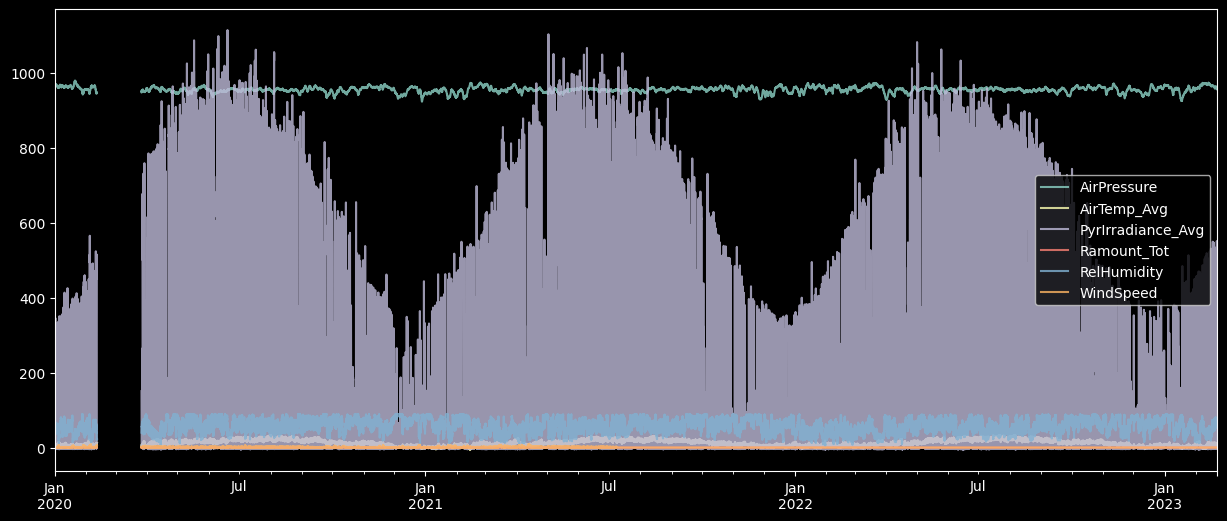

In [10]:
df_meteo.plot(figsize=(15, 6), alpha=0.8)

Visualize the data in df_meters

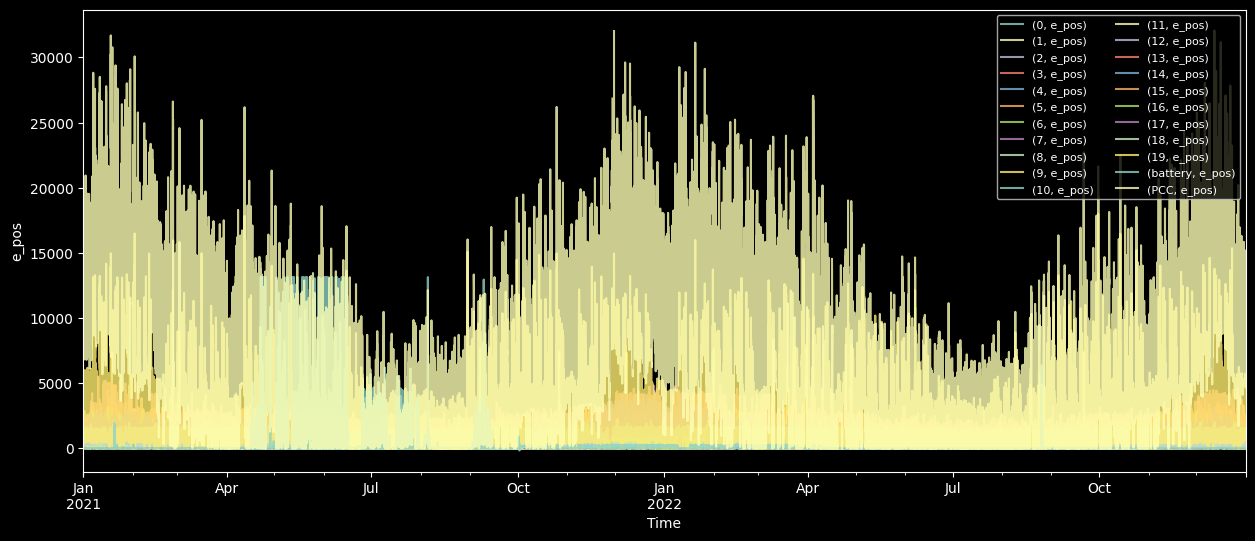

In [11]:
# Plot the e_pos measure in the df_meters dataset
e_pos_cols = [col for col in df_meters.columns if 'e_pos' in col]

# Plot the e_pos columns against the DataFrame's index
df_meters[e_pos_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_pos')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

df_meters_old = df_meters.copy()  # Save for later

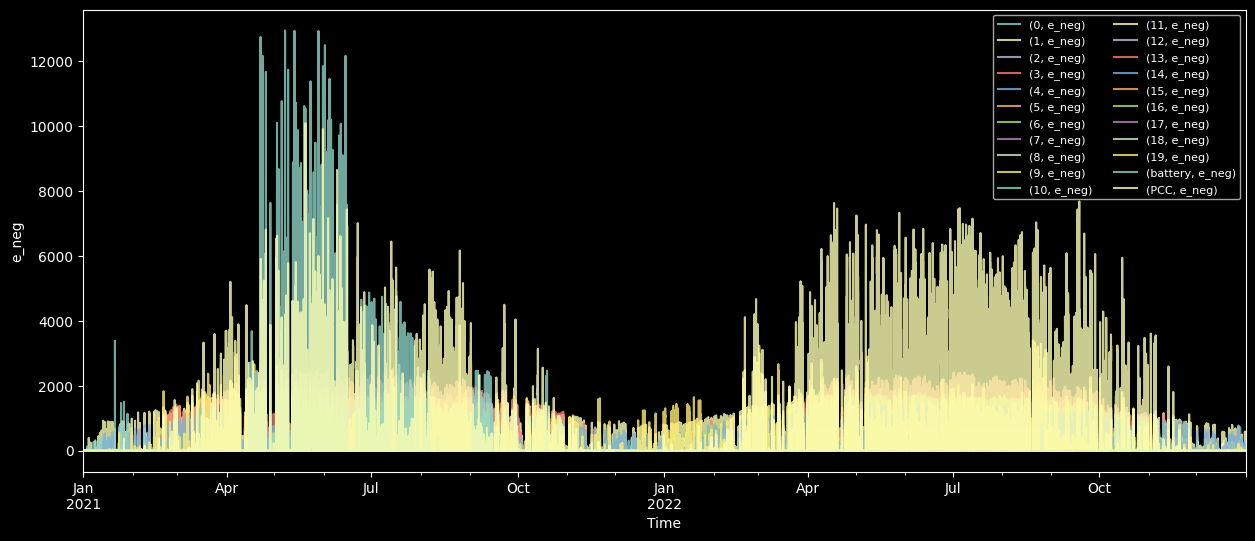

In [12]:
# Plot the e_neg measure in the df_meters dataset
e_neg_cols = [col for col in df_meters.columns if 'e_neg' in col]

# Plot the e_neg columns against the DataFrame's index
df_meters[e_neg_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_neg')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

Visualize the data in df_nwp

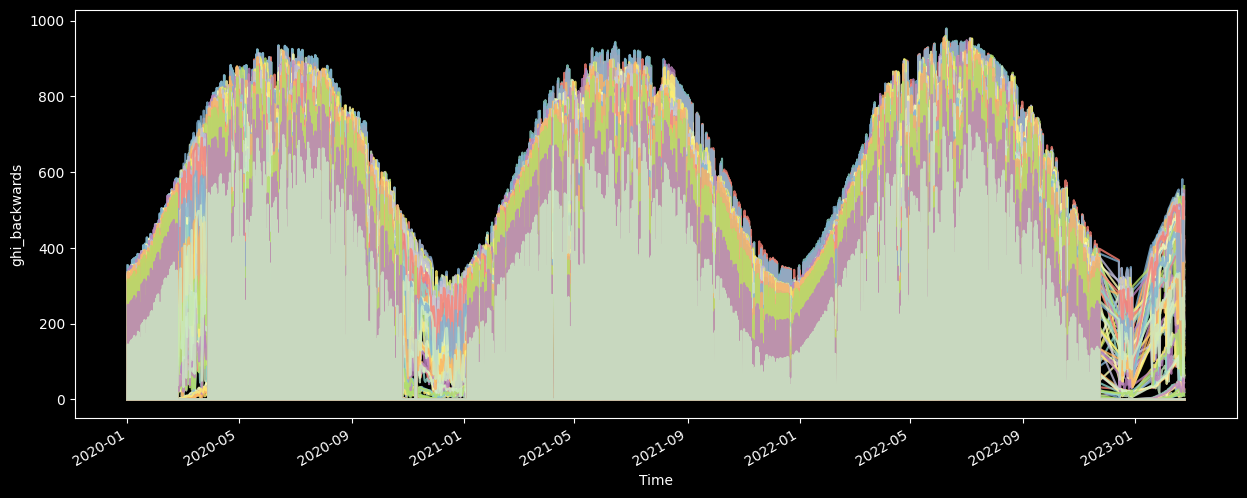

In [13]:
# Plot the ghi_backwards measure in the df_nwp dataset
e_ghi_cols = [col for col in df_nwp.columns if 'ghi_backwards' in col]

# Plot the ghi_backwards columns against the DataFrame's index
df_nwp[e_ghi_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('ghi_backwards')
plt.legend('', frameon=False)
# plt.legend(loc='upper right', ncol=2, fontsize=8)  # Comment label due to size reasons
plt.show()

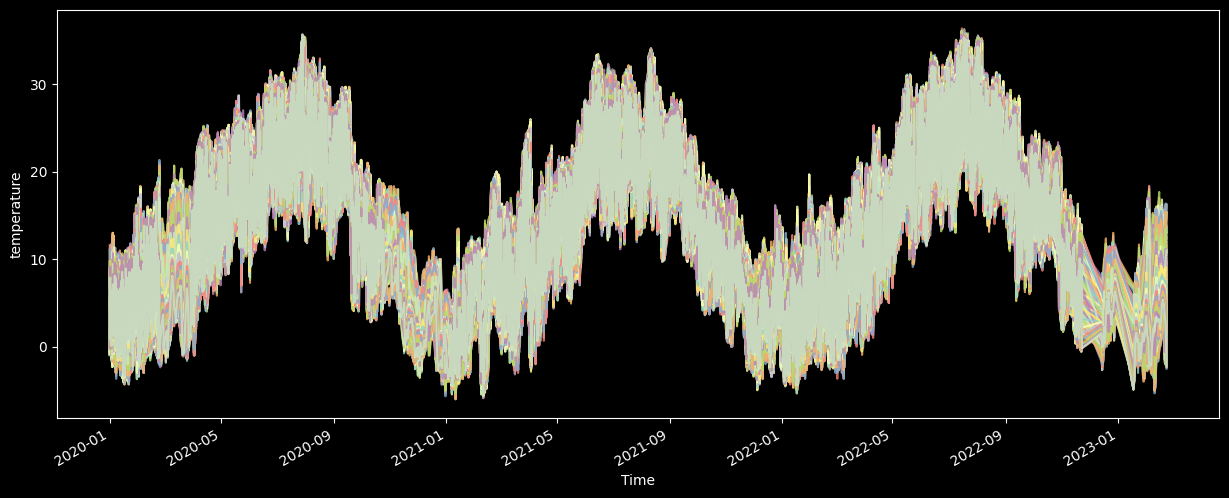

In [14]:
# Plot the temperature measure in the df_nwp dataset
e_temp_cols = [col for col in df_nwp.columns if 'temperature' in col]

# Plot the temperature columns against the DataFrame's index
df_nwp[e_temp_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('temperature')
plt.legend('', frameon=False)
# plt.legend(loc='upper right', ncol=2, fontsize=8)  # Comment label due to size reasons
plt.show()

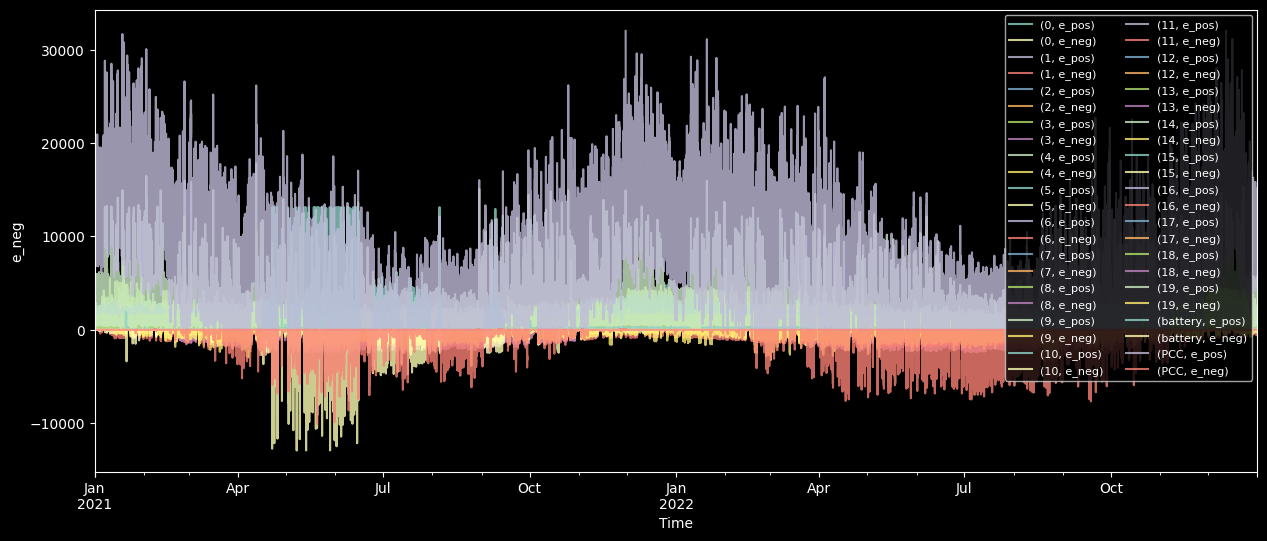

In [15]:
df = df_meters.copy()
df[e_neg_cols] = -df[e_neg_cols]

df.plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_neg')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

# Clean the data

Comments on the data after having explored it:
- It is requested to resample the data at hourly rate
- It is requested to subtract the battery data to the PCC data as there is a discrepancy with the meters data due to the enrgy accumulated i the battery and some electrical dispersions.

In [16]:
# Check for missing values
print('df_meters:\n', df_meters.isna().sum().sum(), '\n---------\n')

print('df_meteo:\n', df_meteo.isna().sum().sum(), '\n---------\n')

print('df_nwp:\n', df_nwp.isna().sum().sum(), '\n---------\n')

df_meters:
 1269 
---------

df_meteo:
 26022 
---------

df_nwp:
 0 
---------



In [17]:
# Check the shapes of the datasets
print('df_meters:\n', df_meters.shape, '\n---------\n')

print('df_meteo:\n', df_meteo.shape, '\n---------\n')

print('df_nwp:\n', df_nwp.shape, '\n---------\n')

df_meters:
 (70080, 44) 
---------

df_meteo:
 (110208, 6) 
---------

df_nwp:
 (2024, 507) 
---------



## Visualize the position of the missing values

<AxesSubplot: >

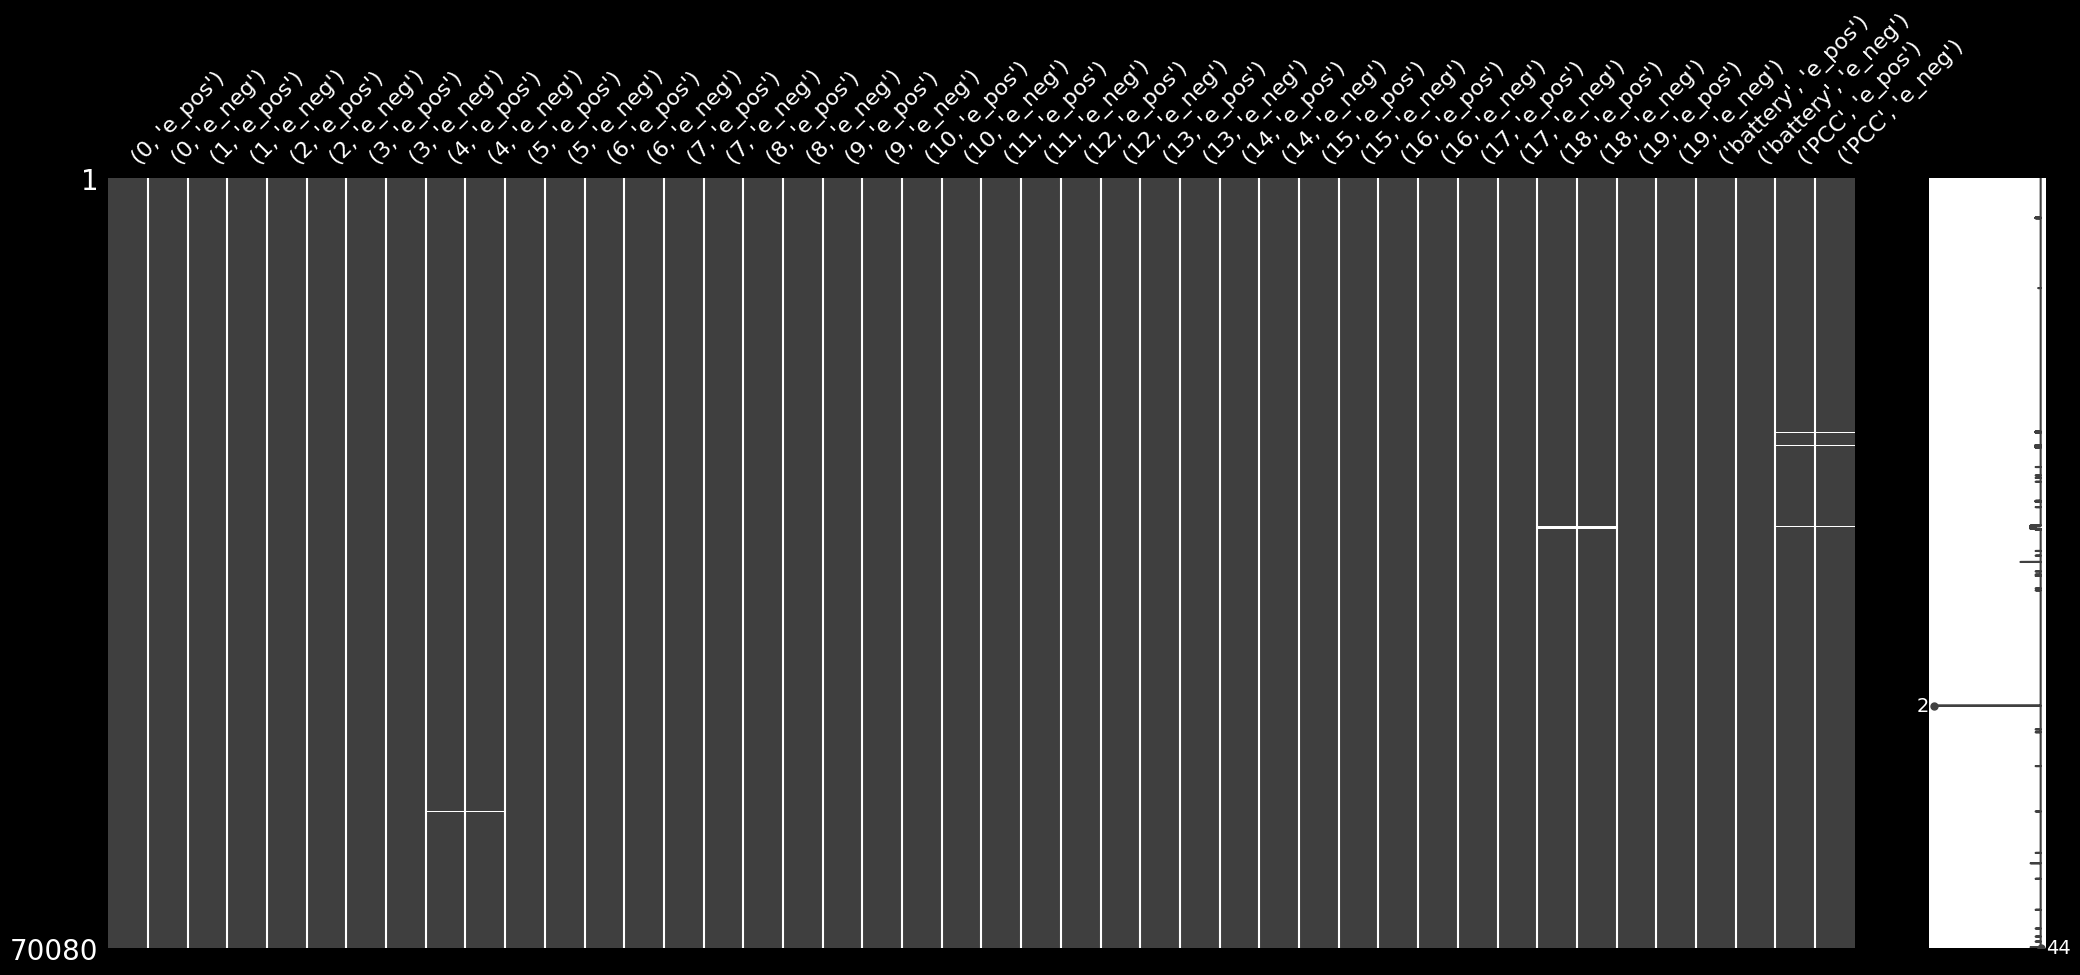

In [18]:
# Visualize the position of null values in the time series of df_meters
msno.matrix(df_meters)

<AxesSubplot: >

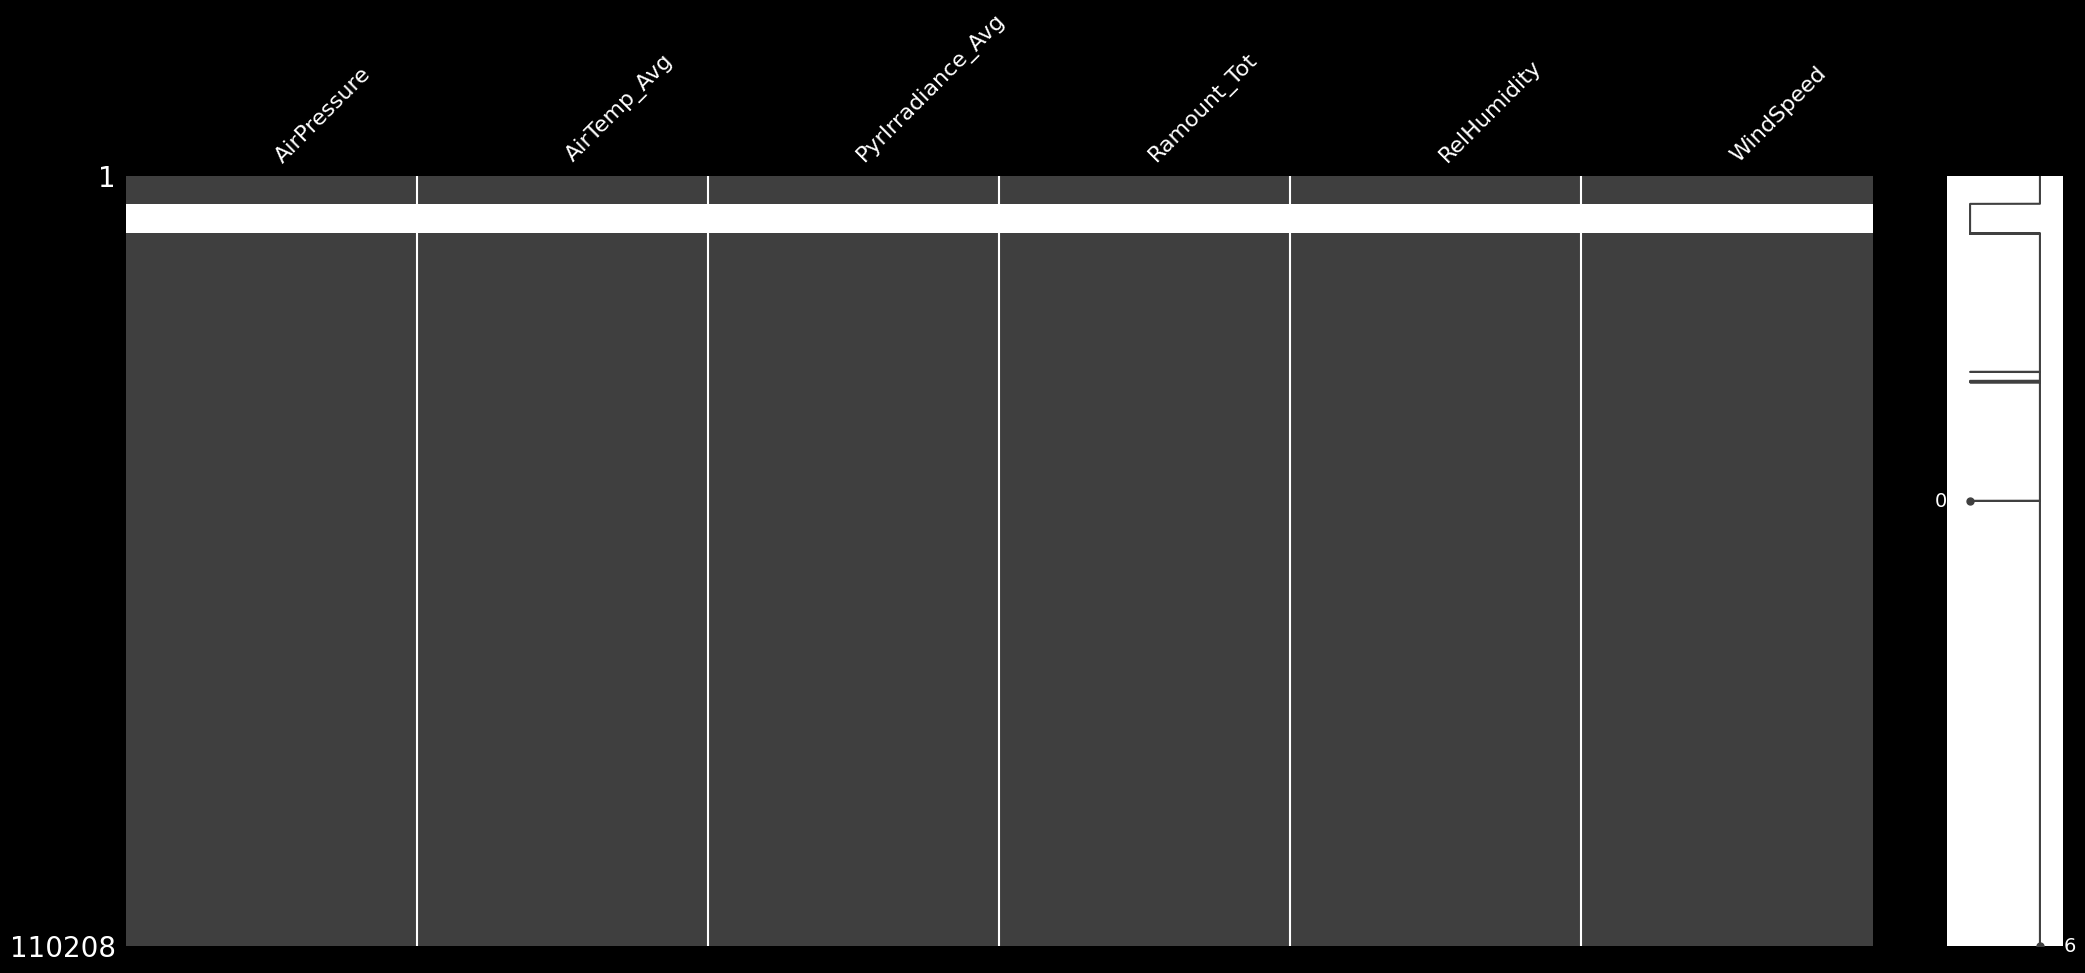

In [19]:
# Visualize the position of null values in the time series of df_meteo
msno.matrix(df_meteo)

<AxesSubplot: >

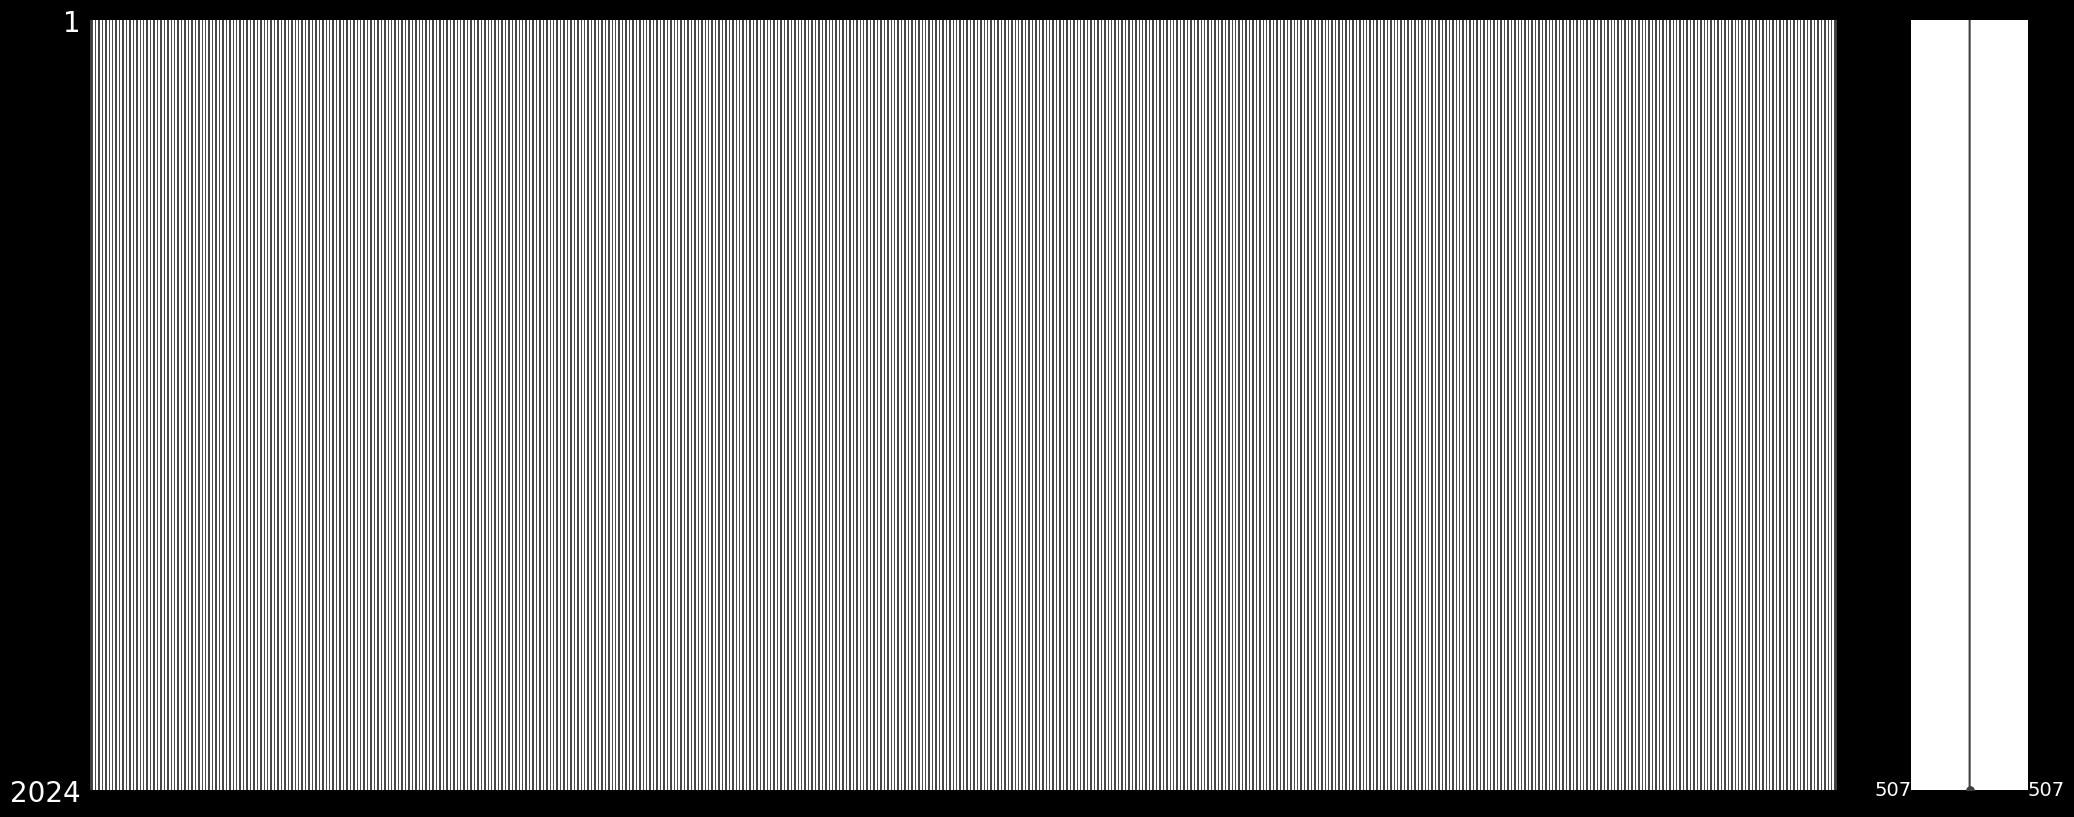

In [20]:
# Visualize the position of null values in the time series of df_nwp
msno.matrix(df_nwp)

## Resample the data at hourly rate

In [21]:
# Check data sampled at 15 minutes intervals in df_meteo
df_meteo.head(3)

,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed
2020-01-01 00:00:00+00:00,965.453333,5.613533,-2.768667,0.0,48.806667,0.617600
2020-01-01 00:15:00+00:00,965.460000,5.544867,-2.425200,0.0,49.060000,1.238600
2020-01-01 00:30:00+00:00,965.353333,5.549267,-2.498133,0.0,48.820000,0.854533


In [22]:
# Check data sampled at 15 minutes intervals in df_meters
df_meters.head(3)

0            1            2            3        \
                           e_pos e_neg  e_pos e_neg  e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  126.0   0.0  974.0   0.0  544.0   0.0  681.0   0.0   
2020-12-31 23:15:00+00:00  102.0   0.0  211.0   0.0  495.0   0.0  606.0   0.0   
2020-12-31 23:30:00+00:00  121.0   0.0  210.0   0.0  233.0   0.0  598.0   0.0   

                                    4        ...     17           18        \
                                e_pos e_neg  ...  e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  142.000000   0.0  ...  670.0   0.0  808.0   0.0   
2020-12-31 23:15:00+00:00  663.000000   0.0  ...  525.0   0.0  513.0   0.0   
2020-12-31 23:30:00+00:00  437.167377   0.0  ...  499.0   0.0  436.0   0.0   

                               19       battery            PCC        
                            e_pos e_neg   e_pos e_neg    e_pos e_neg  
2020-12-31 23:00:00+00:00  1805.0   0.0     1.0   0.0   9142.0   0.0  
2020-12-31 23:15:00+00:00  3082.0   0.0     0.0   0.0  13330.0   0.0  
2020-12-31 23:30:00+00:00   881.0   0.0     1.0   0.0   9095.0   0.0  

[3 rows x 44 columns]

In [23]:
# Resample the data at hourly rate
df_meteo = df_meteo.resample('H').mean()  # Get average meteo values at hourly rate
df_meters = df_meters.resample('H').sum()  # Sum the measurements of meters to get hourly values
# df_nwp = df_nwp.resample('H').interpolate(method='linear')  # Interpolate prediction values to get hourly values

In [24]:
# Check data sampled at 1 hour intervals in df_meeto
df_meteo.head(3)

,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed
2020-01-01 00:00:00+00:00,965.396667,5.586717,-2.524517,0.0,48.945000,0.908617
2020-01-01 01:00:00+00:00,965.388333,5.911933,-2.392700,0.0,47.821667,0.877183
2020-01-01 02:00:00+00:00,965.216667,6.480783,-2.452333,0.0,45.773333,1.068467


In [25]:
# Check data sampled at 1 hour intervals in df_meters
df_meters.head(3)

0             1             2             3  \
                           e_pos e_neg   e_pos e_neg   e_pos e_neg   e_pos   
2020-12-31 23:00:00+00:00  447.0   0.0  1686.0   0.0  1721.0   0.0  2509.0   
2021-01-01 00:00:00+00:00  485.0   0.0   810.0   0.0  1862.0   0.0  2469.0   
2021-01-01 01:00:00+00:00  218.0   0.0  1433.0   0.0  1679.0   0.0  2330.0   

                                           4        ...      17            18  \
                          e_neg        e_pos e_neg  ...   e_pos e_neg   e_pos   
2020-12-31 23:00:00+00:00   0.0  1628.982403   0.0  ...  2389.0   0.0  2119.0   
2021-01-01 00:00:00+00:00   0.0  1445.581219   0.0  ...  3317.0   0.0  1984.0   
2021-01-01 01:00:00+00:00   0.0  1317.436378   0.0  ...  3390.0   0.0  1639.0   

                                     19       battery            PCC        
                          e_neg   e_pos e_neg   e_pos e_neg    e_pos e_neg  
2020-12-31 23:00:00+00:00   0.0  6427.0   0.0     3.0   0.0  40947.0   0.0  
2021-01-01 00:00:00+00:00   0.0  6266.0   0.0     2.0   0.0  37873.0   0.0  
2021-01-01 01:00:00+00:00   0.0  7146.0   0.0     3.0   0.0  40145.0   0.0  

[3 rows x 44 columns]

In [26]:
# We slice the data from '2020-12-31 23:00:00+00:00' to '2022-11-28 22:00:00+00:00' so that we have full data fro all the datasets
start_date = '2021-01-01 00:00:00+00:00'

end_date = '2022-11-28 22:00:00+00:00'

df_meteo = df_meteo.loc[start_date:end_date]
df_meters= df_meters.loc[start_date:end_date]
df_nwp = df_nwp.loc[start_date:end_date]

# sort the columns in the multiindex
sorted_nwp = df_nwp.sort_index(axis=1, level=[0, 1])

In [27]:
sorted_nwp.head(3)

ghi_backwards                                     \
                                    0    1    2    3    4    5    6    7     
2021-01-01 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2021-01-02 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2021-01-03 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                         ... temperature                    \
                             8      9    ...         159   160   161   162   
2021-01-01 00:00:00+00:00  13.60  45.82  ...        3.91  2.65  1.47  0.46   
2021-01-02 00:00:00+00:00  12.95  54.19  ...        2.79  1.40  0.20 -0.97   
2021-01-03 00:00:00+00:00   6.86   5.70  ...        3.67  2.91  2.34  1.89   

                                                               
                            163   164   165   166   167   168  
2021-01-01 00:00:00+00:00 -0.31 -0.74 -0.97 -1.27 -1.62 -1.85  
2021-01-02 00:00:00+00:00 -1.91 -2.71 -3.38 -4.05 -3.93 -3.54  
2021-01-03 00:00:00+00:00  1.57  1.34  1.09  0.76  0.35 -0.24  

[3 rows x 507 columns]

In [28]:
# To have hourly samples in df_nwp we use its predictions for the next hours 

def create_empty_hourly_df(start_date, end_date):
    hourly_df = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date, freq='H'),
                                columns=range(24))
    return hourly_df

def get_hourly(df_preds, df_hourly):
    for i in range(len(df_hourly)):
        time = df_hourly.index[i]
        preds_row = df_preds.loc[df_preds.index <= time].iloc[-1]
        delta = time - preds_row.name  
        hours_diff = delta.total_seconds() / 3600
        df_hourly.iloc[i] = df_preds.loc[df_preds.index <= time].iloc[-1, int(hours_diff):24 + int(hours_diff)].values
    return df_hourly

dfs_list = []
for column in ['ghi_backwards', 'temperature', 'relativehumidity']:
    df = sorted_nwp[column]
    hourly_df = create_empty_hourly_df(start_date, end_date)
    hourly_df = get_hourly(df, hourly_df)
    dfs_list.append(hourly_df)

# concatenate the 3 hourly dfs adding the name of the column as level 1 index of the multiindex
hourly_nwp_df = pd.concat(dfs_list, axis=1, keys=['ghi_backwards', 'temperature', 'relativehumidity'])


In [29]:
df_nwp = hourly_nwp_df
df_nwp

ghi_backwards                                     \
                                     0    1    2    3     4      5      6    
2021-01-01 00:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   
2021-01-01 01:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   
2021-01-01 02:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0   13.6   
2021-01-01 03:00:00+00:00           0.0  0.0  0.0  0.0   0.0   13.6  45.82   
2021-01-01 04:00:00+00:00           0.0  0.0  0.0  0.0  13.6  45.82  72.37   
...                                 ...  ...  ...  ...   ...    ...    ...   
2022-11-28 18:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   
2022-11-28 19:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   
2022-11-28 20:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   
2022-11-28 21:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   
2022-11-28 22:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   

                                                ... relativehumidity         \
                              7      8      9   ...               14     15   
2021-01-01 00:00:00+00:00    0.0   13.6  45.82  ...             87.0   92.0   
2021-01-01 01:00:00+00:00   13.6  45.82  72.37  ...             92.0   98.0   
2021-01-01 02:00:00+00:00  45.82  72.37  59.97  ...             98.0  100.0   
2021-01-01 03:00:00+00:00  72.37  59.97  61.64  ...            100.0   99.0   
2021-01-01 04:00:00+00:00  59.97  61.64  75.82  ...             99.0  100.0   
...                          ...    ...    ...  ...              ...    ...   
2022-11-28 18:00:00+00:00    0.0    0.0    0.0  ...             89.0   79.0   
2022-11-28 19:00:00+00:00    0.0    0.0    0.0  ...             79.0   71.0   
2022-11-28 20:00:00+00:00    0.0    0.0    0.0  ...             71.0   65.0   
2022-11-28 21:00:00+00:00    0.0    0.0    0.0  ...             65.0   61.0   
2022-11-28 22:00:00+00:00    0.0    0.0   1.85  ...             61.0   60.0   

                                                                            \
                              16     17     18     19     20     21     22   
2021-01-01 00:00:00+00:00   98.0  100.0   99.0  100.0  100.0  100.0   99.0   
2021-01-01 01:00:00+00:00  100.0   99.0  100.0  100.0  100.0   99.0  100.0   
2021-01-01 02:00:00+00:00   99.0  100.0  100.0  100.0   99.0  100.0  100.0   
2021-01-01 03:00:00+00:00  100.0  100.0  100.0   99.0  100.0  100.0  100.0   
2021-01-01 04:00:00+00:00  100.0  100.0   99.0  100.0  100.0  100.0  100.0   
...                          ...    ...    ...    ...    ...    ...    ...   
2022-11-28 18:00:00+00:00   71.0   65.0   61.0   60.0   64.0   72.0   80.0   
2022-11-28 19:00:00+00:00   65.0   61.0   60.0   64.0   72.0   80.0   85.0   
2022-11-28 20:00:00+00:00   61.0   60.0   64.0   72.0   80.0   85.0   86.0   
2022-11-28 21:00:00+00:00   60.0   64.0   72.0   80.0   85.0   86.0   87.0   
2022-11-28 22:00:00+00:00   64.0   72.0   80.0   85.0   86.0   87.0   87.0   

                                  
                              23  
2021-01-01 00:00:00+00:00  100.0  
2021-01-01 01:00:00+00:00  100.0  
2021-01-01 02:00:00+00:00  100.0  
2021-01-01 03:00:00+00:00  100.0  
2021-01-01 04:00:00+00:00  100.0  
...                          ...  
2022-11-28 18:00:00+00:00   85.0  
2022-11-28 19:00:00+00:00   86.0  
2022-11-28 20:00:00+00:00   87.0  
2022-11-28 21:00:00+00:00   87.0  
2022-11-28 22:00:00+00:00   86.0  

[16727 rows x 72 columns]

## Remove the multi index

It is not very intuitive to work with a multi-index dataframe, so we'll convert it to a single index dataframe

In [30]:
# Check initial state of df_meters
df_meters.head(1)

0            1             2             3  \
                           e_pos e_neg  e_pos e_neg   e_pos e_neg   e_pos   
2021-01-01 00:00:00+00:00  485.0   0.0  810.0   0.0  1862.0   0.0  2469.0   

                                           4        ...      17            18  \
                          e_neg        e_pos e_neg  ...   e_pos e_neg   e_pos   
2021-01-01 00:00:00+00:00   0.0  1445.581219   0.0  ...  3317.0   0.0  1984.0   

                                     19       battery            PCC        
                          e_neg   e_pos e_neg   e_pos e_neg    e_pos e_neg  
2021-01-01 00:00:00+00:00   0.0  6266.0   0.0     2.0   0.0  37873.0   0.0  

[1 rows x 44 columns]

In [31]:
# Check initial state of df_nwp
df_nwp.head(1)

ghi_backwards                                     \
                                     0    1    2    3    4    5    6    7    
2021-01-01 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                        ... relativehumidity              \
                             8      9   ...               14    15    16   
2021-01-01 00:00:00+00:00  13.6  45.82  ...             87.0  92.0  98.0   

                                                                          
                              17    18     19     20     21    22     23  
2021-01-01 00:00:00+00:00  100.0  99.0  100.0  100.0  100.0  99.0  100.0  

[1 rows x 72 columns]

In [32]:
# Remove the multi index from df_meters and df_nwp
# df_meteo already has no multi index
df_meters_multi = df_meters
df_meters.columns = [f'{col[1]}_{col[0]}' for col in df_meters.columns]
df_nwp.columns = [f'{col[1]}_{col[0]}' for col in df_nwp.columns]

In [33]:
# Check result on df_meters
df_meters.head(1)

,e_pos_0,e_neg_0,e_pos_1,e_neg_1,e_pos_2,e_neg_2,e_pos_3,e_neg_3,e_pos_4,e_neg_4,...,e_pos_17,e_neg_17,e_pos_18,e_neg_18,e_pos_19,e_neg_19,e_pos_battery,e_neg_battery,e_pos_PCC,e_neg_PCC
2021-01-01 00:00:00+00:00,485.0,0.0,810.0,0.0,1862.0,0.0,2469.0,0.0,1445.581219,0.0,...,3317.0,0.0,1984.0,0.0,6266.0,0.0,2.0,0.0,37873.0,0.0


In [34]:
# Check result on df_nwp
df_nwp.head(1)

,0_ghi_backwards,1_ghi_backwards,2_ghi_backwards,3_ghi_backwards,4_ghi_backwards,5_ghi_backwards,6_ghi_backwards,7_ghi_backwards,8_ghi_backwards,9_ghi_backwards,...,14_relativehumidity,15_relativehumidity,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity
2021-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.6,45.82,...,87.0,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0


## Sum up the battery data to the PCC data

We had to do it because it happens that sometimes the battery starts storing and providing energy to the stations

In [35]:
df_meters

,e_pos_0,e_neg_0,e_pos_1,e_neg_1,e_pos_2,e_neg_2,e_pos_3,e_neg_3,e_pos_4,e_neg_4,...,e_pos_17,e_neg_17,e_pos_18,e_neg_18,e_pos_19,e_neg_19,e_pos_battery,e_neg_battery,e_pos_PCC,e_neg_PCC
2021-01-01 00:00:00+00:00,485.0,0.0,810.0,0.0,1862.0,0.0,2469.0,0.0,1445.581219,0.0,...,3317.0,0.0,1984.0,0.0,6266.0,0.0,2.0,0.0,37873.0,0.0
2021-01-01 01:00:00+00:00,218.0,0.0,1433.0,0.0,1679.0,0.0,2330.0,0.0,1317.436378,0.0,...,3390.0,0.0,1639.0,0.0,7146.0,0.0,3.0,0.0,40145.0,0.0
2021-01-01 02:00:00+00:00,224.0,0.0,2046.0,0.0,1749.0,0.0,2457.0,0.0,1185.000000,0.0,...,3174.0,0.0,1421.0,0.0,7299.0,0.0,2.0,0.0,35965.0,0.0
2021-01-01 03:00:00+00:00,287.0,0.0,1688.0,0.0,1879.0,0.0,2123.0,0.0,558.000000,0.0,...,4358.0,0.0,1759.0,0.0,6286.0,0.0,3.0,0.0,37186.0,0.0
2021-01-01 04:00:00+00:00,227.0,0.0,1762.0,0.0,1998.0,0.0,4850.0,0.0,522.000000,0.0,...,2974.0,0.0,2251.0,0.0,6120.0,0.0,3.0,0.0,46072.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-28 18:00:00+00:00,262.0,0.0,2515.0,0.0,2251.0,0.0,2948.0,0.0,1903.000000,0.0,...,4575.0,0.0,1302.0,0.0,12066.0,0.0,123.0,0.0,56515.0,0.0
2022-11-28 19:00:00+00:00,1037.0,0.0,2458.0,0.0,1263.0,0.0,3406.0,0.0,1518.000000,0.0,...,4488.0,0.0,716.0,0.0,9108.0,0.0,121.0,0.0,53616.0,0.0
2022-11-28 20:00:00+00:00,948.0,0.0,637.0,0.0,1235.0,0.0,2146.0,0.0,1800.000000,0.0,...,1466.0,0.0,711.0,0.0,8760.0,0.0,126.0,0.0,36797.0,0.0
2022-11-28 21:00:00+00:00,215.0,0.0,464.0,0.0,1191.0,0.0,1159.0,0.0,1059.000000,0.0,...,4084.0,0.0,609.0,0.0,10613.0,0.0,129.0,0.0,43726.0,0.0


In [36]:
# Check PCC data
df_meters['e_pos_PCC'].head(3)

2021-01-01 00:00:00+00:00    37873.0
2021-01-01 01:00:00+00:00    40145.0
2021-01-01 02:00:00+00:00    35965.0
Freq: H, Name: e_pos_PCC, dtype: float64

In [37]:
# Check battery data
df_meters['e_pos_battery'].head(3)

2021-01-01 00:00:00+00:00    2.0
2021-01-01 01:00:00+00:00    3.0
2021-01-01 02:00:00+00:00    2.0
Freq: H, Name: e_pos_battery, dtype: float64

In [38]:
# Create the columns PCC_batt
# Fortunately the data is aligned, so we can simply sum the features
df_meters['e_pos_PCC_batt'] = df_meters['e_pos_PCC'] - df_meters['e_pos_battery']
df_meters['e_neg_PCC_batt'] = df_meters['e_neg_PCC'] - df_meters['e_neg_battery']

In [39]:
# Check if the new 'PCC_batt' columns were added
df_meters.columns[-5:]

Index(['e_neg_battery', 'e_pos_PCC', 'e_neg_PCC', 'e_pos_PCC_batt',
       'e_neg_PCC_batt'],
      dtype='object')

In [40]:
# Check that the sum was successful
df_meters[['e_pos_PCC_batt', 'e_pos_battery', 'e_pos_PCC']].head(3)

# The sum was successfull
# We'll keep the old columns about 'PCC' and 'battery' in case we'll need them later

,e_pos_PCC_batt,e_pos_battery,e_pos_PCC
2021-01-01 00:00:00+00:00,37871.0,2.0,37873.0
2021-01-01 01:00:00+00:00,40142.0,3.0,40145.0
2021-01-01 02:00:00+00:00,35963.0,2.0,35965.0


In [41]:
df_meters_stats = df_meters.copy()

In [42]:
# Compute sum of meters values and loss of PCC
df_meters_stats['sum_e_pos_meters'] = df_meters_stats[[f'e_pos_{i}' for i in range(20)]].sum(axis=1)
df_meters_stats['sum_e_neg_meters'] = df_meters_stats[[f'e_neg_{i}' for i in range(20)]].sum(axis=1)
df_meters_stats['sum_meters'] = df_meters_stats['sum_e_pos_meters'] - df_meters_stats['sum_e_neg_meters']
df_meters_stats['loss_e_pos_meters'] = df_meters_stats['e_pos_PCC'] - df_meters_stats['sum_e_pos_meters']
df_meters_stats['loss_e_neg_meters'] = df_meters_stats['e_neg_PCC'] - df_meters_stats['sum_e_neg_meters']
df_meters_stats['loss_meters'] = df_meters_stats['loss_e_pos_meters']- df_meters_stats['loss_e_neg_meters']
df_meters_stats['sum_PCC'] = df_meters_stats['e_pos_PCC_batt'] - df_meters_stats['e_neg_PCC_batt']

In [43]:
# Select columns of interest
e_pos_meters_cols = df_meters_stats[['e_pos_PCC_batt', 'sum_e_pos_meters', 'loss_e_pos_meters']]
e_neg_meters_cols = df_meters_stats[['e_neg_PCC_batt', 'sum_e_neg_meters', 'loss_e_neg_meters']]
meters_cols = df_meters_stats[['loss_meters', 'sum_meters', 'sum_PCC']]

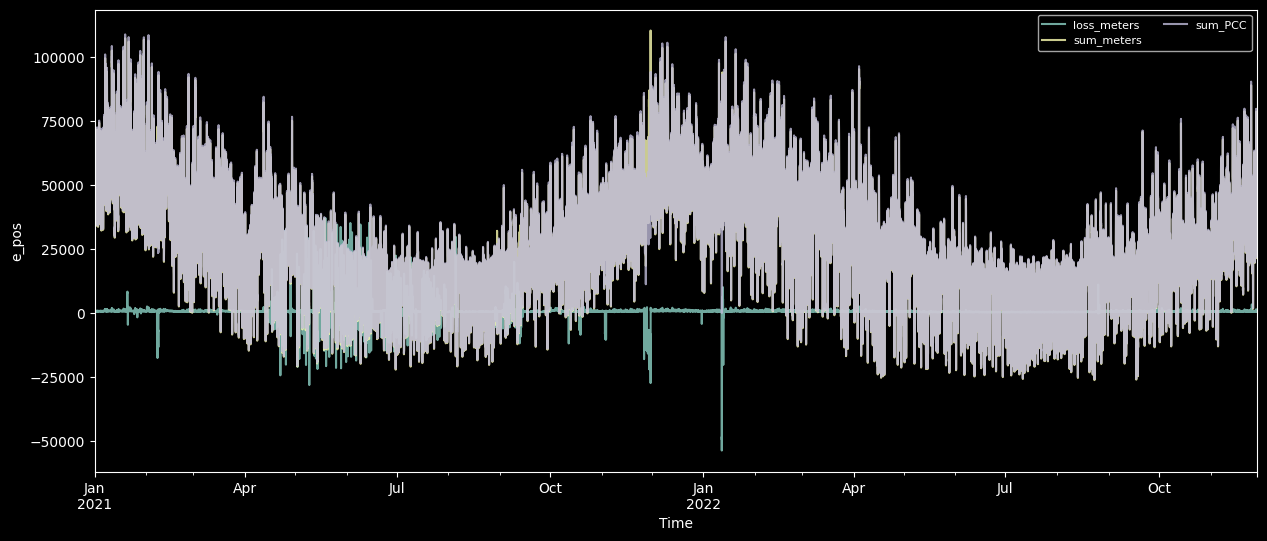

In [44]:
# Check visually discrepancies between PCC_batt and the sum of the meters values
meters_cols.plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_pos')
plt.legend('', frameon=False)
plt.legend(loc='upper right', ncol=2, fontsize=8)  # Comment label due to size reasons
plt.show()

# The loss is very small besides some spikes in the signal, which could also be due to outliers (handled below).
# We'll use the loss as a feature in the models to take into account the possibility of losses.

## Impute the missing values on df_meters

In [45]:
# Check for nulls in the datasets
print('df_meters:\n', df_meters.isna().sum().sum(), '\n---------\n')

print('df_meteo:\n', df_meteo.isna().sum().sum(), '\n---------\n')

print('df_nwp:\n', df_nwp.isna().sum().sum(), '\n---------\n')

df_meters:
 0 
---------

df_meteo:
 0 
---------

df_nwp:
 0 
---------



<AxesSubplot: >

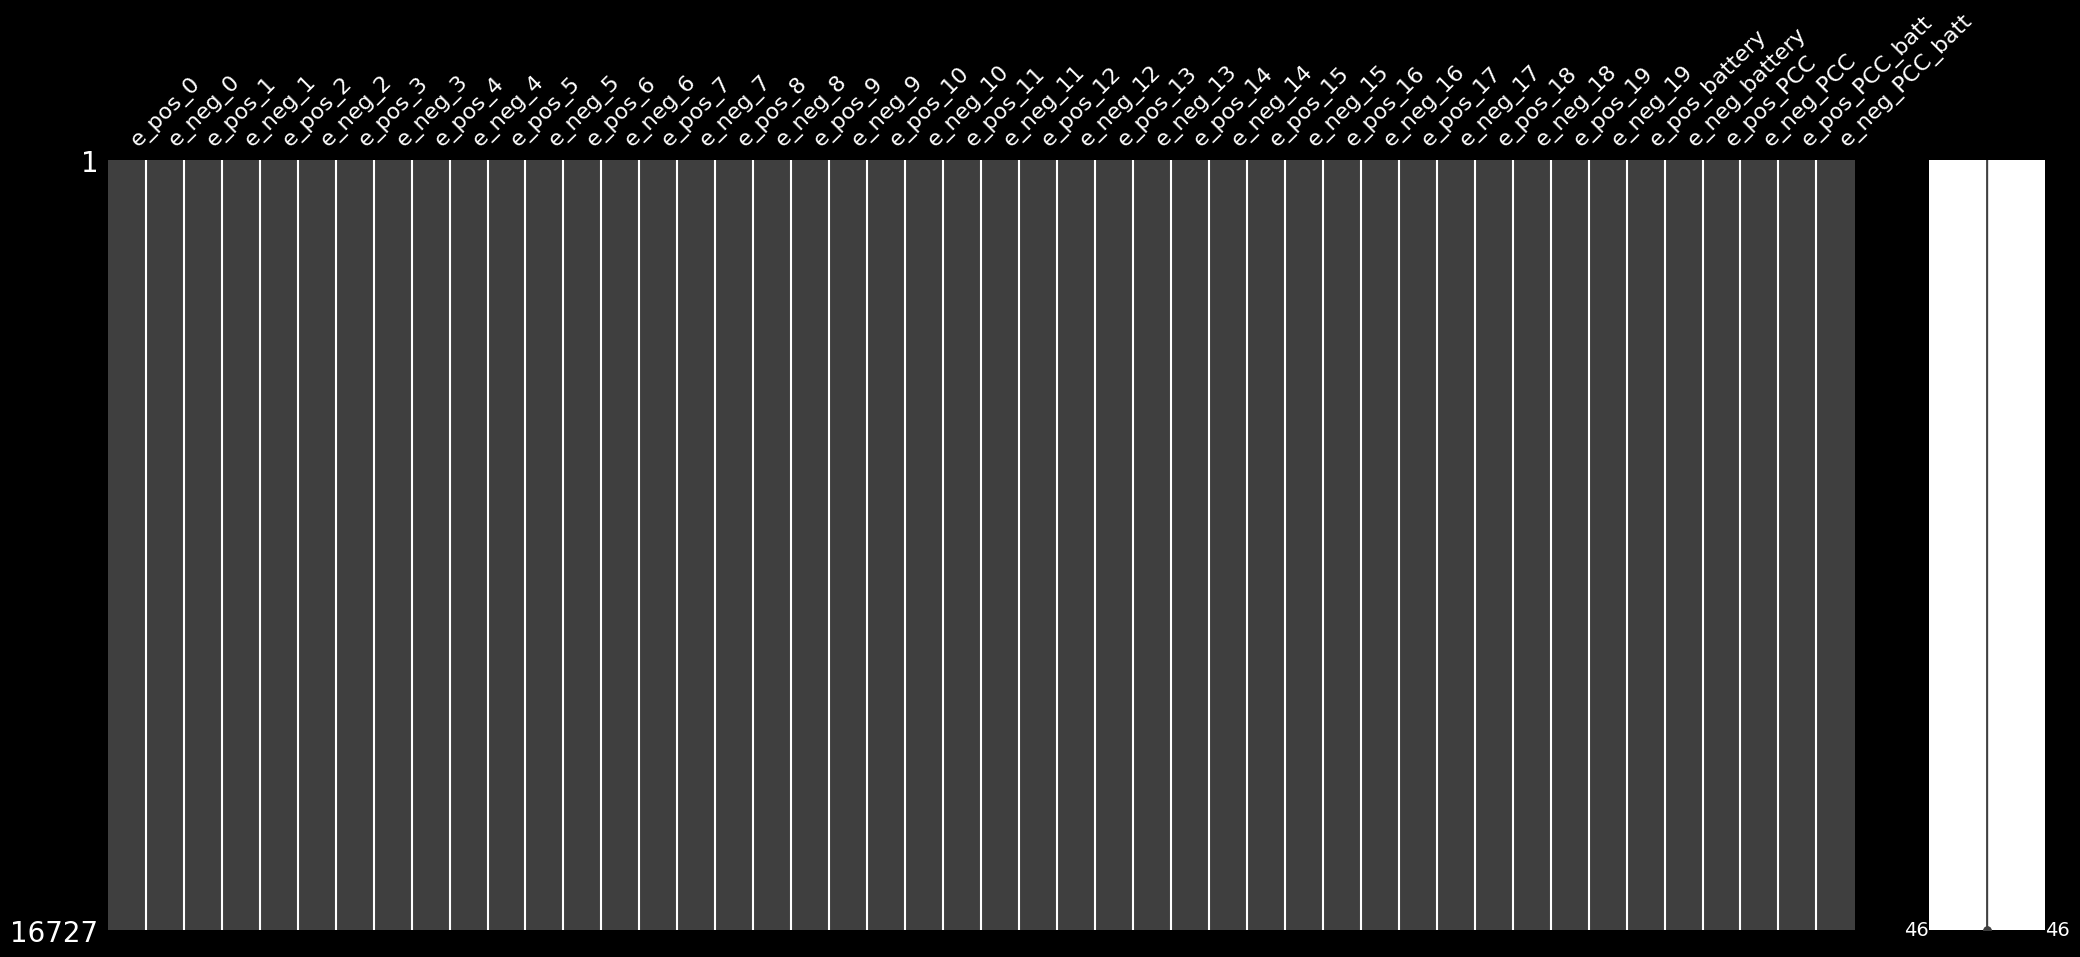

In [46]:
# Visualize the position of the missing values 
msno.matrix(df_meters)

In [47]:
# Impute missing values with the mean
print('Nulls before numerical features imputation:', df_meters.isna().sum().sum())

df_meters = df_meters.fillna(df_meters.mean())

print('Nulls after numerical features imputation:', df_meters.isna().sum().sum())

Nulls before numerical features imputation: 0
Nulls after numerical features imputation: 0


## Merge the datasets to get a single dataset with all the features
Some data has different time windows, so there will be some NaN values.
We decided to drop the windows where we don't have data from all the features.

In [48]:
df_meters.insert(1, 'loss_meters', df_meters_stats['loss_meters'])

In [49]:
# Check the range of dates in the three datasets
print('Start date:\n',
      'df_meters:', df_meters.index.min(), '\n',
      'df_meteo:', df_meteo.index.min(), '\n',
      'df_nwp:', df_nwp.index.min(), '\n')
      
print('End date:\n',
      'df_meters:', df_meters.index.max(), '\n',
      'df_meteo:', df_meteo.index.max(), '\n',
      'df_nwp:', df_nwp.index.max())

Start date:
 df_meters: 2021-01-01 00:00:00+00:00 
 df_meteo: 2021-01-01 00:00:00+00:00 
 df_nwp: 2021-01-01 00:00:00+00:00 

End date:
 df_meters: 2022-11-28 22:00:00+00:00 
 df_meteo: 2022-11-28 22:00:00+00:00 
 df_nwp: 2022-11-28 22:00:00+00:00


In [50]:
df = pd.concat([df_meters, df_meteo, df_nwp], axis=1)

In [51]:
df.shape

(16727, 125)

In [52]:
df.head(3)

,e_pos_0,loss_meters,e_neg_0,e_pos_1,e_neg_1,e_pos_2,e_neg_2,e_pos_3,e_neg_3,e_pos_4,...,14_relativehumidity,15_relativehumidity,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity
2021-01-01 00:00:00+00:00,485.0,-50.581219,0.0,810.0,0.0,1862.0,0.0,2469.0,0.0,1445.581219,...,87.0,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0
2021-01-01 01:00:00+00:00,218.0,766.563622,0.0,1433.0,0.0,1679.0,0.0,2330.0,0.0,1317.436378,...,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0
2021-01-01 02:00:00+00:00,224.0,460.000000,0.0,2046.0,0.0,1749.0,0.0,2457.0,0.0,1185.000000,...,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0


## Sum up the data about station 10 and 11

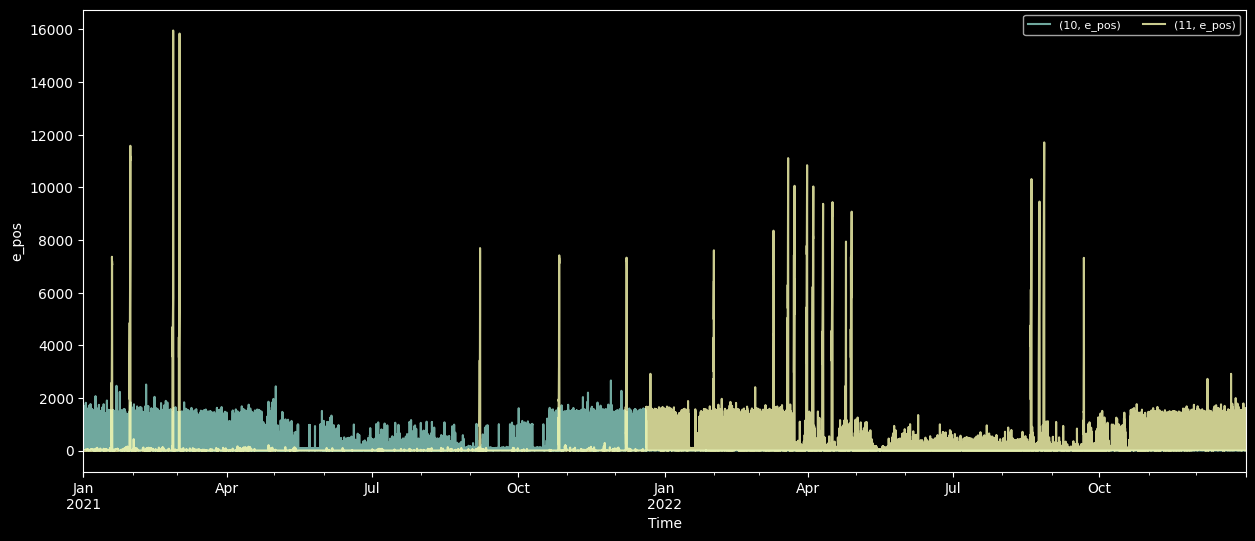

In [53]:
# The data in station 10 and 11 seem to be from the same source/people who changed station, so we'll sum them up
df_meters_old[e_pos_cols[10:12]].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_pos')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

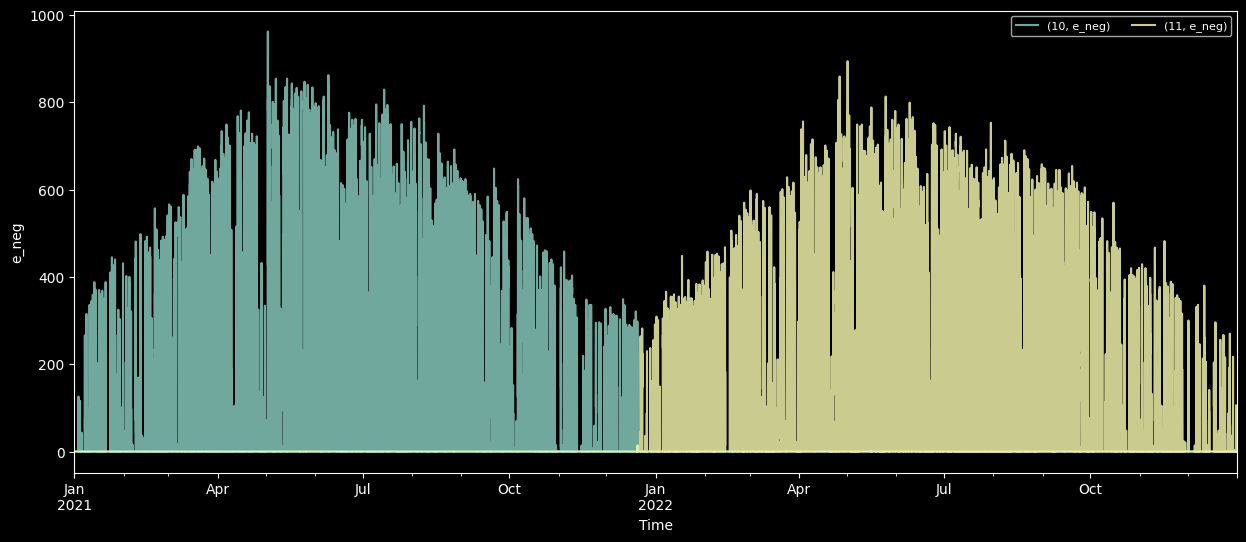

In [54]:
df_meters_old[e_neg_cols[10:12]].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_neg')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

In [55]:
# Identify the date in which the two stations were swapped
trial_pos = df_meters_old[e_pos_cols[10:12]]
trial_neg = df_meters_old[e_neg_cols[10:12]]

In [56]:
trial_pos = trial_pos.reset_index()
trial_neg = trial_neg.reset_index()

In [57]:
# Get the number of samples in december 2021
trial_pos[(trial_pos['index'] >= '2021-12-01') & (trial_pos['index'] < '2022-01-01')].shape

(2976, 3)

In [58]:
# Inspect e_pos values in december 2021
trial_pos[(trial_pos['index'] >= '2021-12-01') & (trial_pos['index'] < '2022-01-01')][1870:1885]

,index,10,11
,,e_pos,e_pos
33938,2021-12-20 11:30:00+00:00,0.0,0.0
33939,2021-12-20 11:45:00+00:00,0.0,0.0
33940,2021-12-20 12:00:00+00:00,0.0,0.0
33941,2021-12-20 12:15:00+00:00,0.0,0.0
33942,2021-12-20 12:30:00+00:00,6.0,0.0
33943,2021-12-20 12:45:00+00:00,0.0,0.0
33944,2021-12-20 13:00:00+00:00,0.0,NaN
33945,2021-12-20 13:15:00+00:00,0.0,NaN
33946,2021-12-20 13:30:00+00:00,0.0,NaN


In [59]:
# Inspect e_neg values in december 2021
trial_neg[(trial_neg['index'] >= '2021-12-01') & (trial_neg['index'] < '2022-01-01')][1870:1885]

,index,10,11
,,e_neg,e_neg
33938,2021-12-20 11:30:00+00:00,290.0,0.0
33939,2021-12-20 11:45:00+00:00,298.0,0.0
33940,2021-12-20 12:00:00+00:00,288.0,0.0
33941,2021-12-20 12:15:00+00:00,275.0,0.0
33942,2021-12-20 12:30:00+00:00,238.0,0.0
33943,2021-12-20 12:45:00+00:00,211.0,0.0
33944,2021-12-20 13:00:00+00:00,0.0,NaN
33945,2021-12-20 13:15:00+00:00,0.0,NaN
33946,2021-12-20 13:30:00+00:00,0.0,NaN


In [60]:
# The switch happens in the days around '2021-12-20 13:00:00+00:00'

# Add Date column to the dataframe
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)

df['Date'] = pd.to_datetime(df['Date'])

# Set e_pos_10 and e_neg_10 to 0 when Date > '2021-12-20 13:00:00+00:00'
df.loc[df['Date'] > pd.to_datetime('2021-12-20 13:00:00+00:00'), ['e_pos_10', 'e_neg_10']] = 0

# Set e_pos_11 and e_neg_11 to 0 when Date < '2021-12-20 13:00:00+00:00'
df.loc[df['Date'] < pd.to_datetime('2021-12-20 13:00:00+00:00'), ['e_pos_11', 'e_neg_11']] = 0

# Adjust the dataset
df['e_neg_10'] = df['e_neg_11']
df['e_pos_10'] = df['e_pos_11']
df =df.drop(columns=['e_pos_11', 'e_neg_11'])
for i in range(12, 20):
    df = df.rename(columns={
        f"e_pos_{i}": f"e_pos_{i-1}",
        f"e_neg_{i}": f"e_neg_{i-1}",
    })


df.head(3)

,Date,e_pos_0,loss_meters,e_neg_0,e_pos_1,e_neg_1,e_pos_2,e_neg_2,e_pos_3,e_neg_3,...,14_relativehumidity,15_relativehumidity,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity
0,2021-01-01 00:00:00+00:00,485.0,-50.581219,0.0,810.0,0.0,1862.0,0.0,2469.0,0.0,...,87.0,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0
1,2021-01-01 01:00:00+00:00,218.0,766.563622,0.0,1433.0,0.0,1679.0,0.0,2330.0,0.0,...,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0
2,2021-01-01 02:00:00+00:00,224.0,460.000000,0.0,2046.0,0.0,1749.0,0.0,2457.0,0.0,...,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0


In [61]:
# Do the same on just df_meters because we need it to perform other tasks
# Add Date column to the dataframe
df_meters.reset_index(inplace=True)
df_meters.rename(columns={'index': 'Date'}, inplace=True)

df_meters['Date'] = pd.to_datetime(df_meters['Date'])

# Set e_pos_10 and e_neg_10 to 0 when Date > '2021-12-20 13:00:00+00:00'
df_meters.loc[df_meters['Date'] > pd.to_datetime('2021-12-20 13:00:00+00:00'), ['e_pos_10', 'e_neg_10']] = 0

# Set e_pos_11 and e_neg_11 to 0 when Date < '2021-12-20 13:00:00+00:00'
df_meters.loc[df_meters['Date'] < pd.to_datetime('2021-12-20 13:00:00+00:00'), ['e_pos_11', 'e_neg_11']] = 0

# Adjust the dataset
df_meters['e_neg_10'] = df_meters['e_neg_11']
df_meters['e_pos_10'] = df_meters['e_pos_11']
df_meters = df_meters.drop(columns=['e_pos_11', 'e_neg_11'])
for i in range(12, 20):
    df_meters = df_meters.rename(columns={
        f"e_pos_{i}": f"e_pos_{i-1}",
        f"e_neg_{i}": f"e_neg_{i-1}",
    })


df_meters.head(3)

,Date,e_pos_0,loss_meters,e_neg_0,e_pos_1,e_neg_1,e_pos_2,e_neg_2,e_pos_3,e_neg_3,...,e_pos_17,e_neg_17,e_pos_18,e_neg_18,e_pos_battery,e_neg_battery,e_pos_PCC,e_neg_PCC,e_pos_PCC_batt,e_neg_PCC_batt
0,2021-01-01 00:00:00+00:00,485.0,-50.581219,0.0,810.0,0.0,1862.0,0.0,2469.0,0.0,...,1984.0,0.0,6266.0,0.0,2.0,0.0,37873.0,0.0,37871.0,0.0
1,2021-01-01 01:00:00+00:00,218.0,766.563622,0.0,1433.0,0.0,1679.0,0.0,2330.0,0.0,...,1639.0,0.0,7146.0,0.0,3.0,0.0,40145.0,0.0,40142.0,0.0
2,2021-01-01 02:00:00+00:00,224.0,460.000000,0.0,2046.0,0.0,1749.0,0.0,2457.0,0.0,...,1421.0,0.0,7299.0,0.0,2.0,0.0,35965.0,0.0,35963.0,0.0


## Get columns e_pos and e_neg containing the concatenatenated values of all the stations

In [62]:
df_new = pd.DataFrame()
df_meters_temp = df_meters.copy()

for i in range(19):
    if i == 0:
        df_new[f'e_pos'] = df_meters_temp[f'e_pos_{i}']
        df_new[f'e_neg'] = df_meters_temp[f'e_neg_{i}']
        df_new['y'] = df_meters_temp[f'e_pos_{i}'] - df_meters_temp[f'e_neg_{i}']
        df_new['unique_id'] = i
        df_new['ds'] = df_meters_temp['Date']
    else:
        df_loop = pd.DataFrame()
        df_loop[f'e_pos'] = df_meters_temp[f'e_pos_{i}']
        df_loop[f'e_neg'] = df_meters_temp[f'e_neg_{i}']
        df_loop['y'] = df_meters_temp[f'e_pos_{i}'] - df_meters_temp[f'e_neg_{i}']
        df_loop['unique_id'] = i
        df_loop['ds'] = df_meters_temp['Date']
        df_new = pd.concat([df_new, df_loop], axis=0)

df_new.reset_index(drop=True, inplace=True)
# df_new[df_new['unique_id'] == 1]
# df_new.unique_id.unique()

e_pos_series = df_new['e_pos']
e_neg_series = df_new['e_neg']

df_new.pop('e_pos')
df_new.pop('e_neg')

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
317808    0.0
317809    0.0
317810    0.0
317811    0.0
317812    0.0
Name: e_neg, Length: 317813, dtype: float64

In [63]:
df

,Date,e_pos_0,loss_meters,e_neg_0,e_pos_1,e_neg_1,e_pos_2,e_neg_2,e_pos_3,e_neg_3,...,14_relativehumidity,15_relativehumidity,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity
0,2021-01-01 00:00:00+00:00,485.0,-50.581219,0.0,810.0,0.0,1862.0,0.0,2469.0,0.0,...,87.0,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0
1,2021-01-01 01:00:00+00:00,218.0,766.563622,0.0,1433.0,0.0,1679.0,0.0,2330.0,0.0,...,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0
2,2021-01-01 02:00:00+00:00,224.0,460.000000,0.0,2046.0,0.0,1749.0,0.0,2457.0,0.0,...,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0
3,2021-01-01 03:00:00+00:00,287.0,489.000000,0.0,1688.0,0.0,1879.0,0.0,2123.0,0.0,...,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0,100.0
4,2021-01-01 04:00:00+00:00,227.0,522.000000,0.0,1762.0,0.0,1998.0,0.0,4850.0,0.0,...,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16722,2022-11-28 18:00:00+00:00,262.0,643.000000,0.0,2515.0,0.0,2251.0,0.0,2948.0,0.0,...,89.0,79.0,71.0,65.0,61.0,60.0,64.0,72.0,80.0,85.0
16723,2022-11-28 19:00:00+00:00,1037.0,629.000000,0.0,2458.0,0.0,1263.0,0.0,3406.0,0.0,...,79.0,71.0,65.0,61.0,60.0,64.0,72.0,80.0,85.0,86.0
16724,2022-11-28 20:00:00+00:00,948.0,543.000000,0.0,637.0,0.0,1235.0,0.0,2146.0,0.0,...,71.0,65.0,61.0,60.0,64.0,72.0,80.0,85.0,86.0,87.0
16725,2022-11-28 21:00:00+00:00,215.0,605.000000,0.0,464.0,0.0,1191.0,0.0,1159.0,0.0,...,65.0,61.0,60.0,64.0,72.0,80.0,85.0,86.0,87.0,87.0


## Drop unused columns and add useful features

In [64]:
# Add the sum of e_pos and e_neg of PCC_batt
pcc_pos = df.pop('e_pos_PCC_batt')
pcc_neg = df.pop('e_neg_PCC_batt')
pcc_pos_neg_sum = pcc_pos - pcc_neg
# Insert the columns of interest in the first columns after Date
df.insert(1, 'PCC_batt_sum', pcc_pos_neg_sum)

In [65]:
df

,Date,PCC_batt_sum,e_pos_0,loss_meters,e_neg_0,e_pos_1,e_neg_1,e_pos_2,e_neg_2,e_pos_3,...,14_relativehumidity,15_relativehumidity,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity
0,2021-01-01 00:00:00+00:00,37871.0,485.0,-50.581219,0.0,810.0,0.0,1862.0,0.0,2469.0,...,87.0,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0
1,2021-01-01 01:00:00+00:00,40142.0,218.0,766.563622,0.0,1433.0,0.0,1679.0,0.0,2330.0,...,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0
2,2021-01-01 02:00:00+00:00,35963.0,224.0,460.000000,0.0,2046.0,0.0,1749.0,0.0,2457.0,...,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0
3,2021-01-01 03:00:00+00:00,37183.0,287.0,489.000000,0.0,1688.0,0.0,1879.0,0.0,2123.0,...,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0,100.0
4,2021-01-01 04:00:00+00:00,46069.0,227.0,522.000000,0.0,1762.0,0.0,1998.0,0.0,4850.0,...,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16722,2022-11-28 18:00:00+00:00,56392.0,262.0,643.000000,0.0,2515.0,0.0,2251.0,0.0,2948.0,...,89.0,79.0,71.0,65.0,61.0,60.0,64.0,72.0,80.0,85.0
16723,2022-11-28 19:00:00+00:00,53495.0,1037.0,629.000000,0.0,2458.0,0.0,1263.0,0.0,3406.0,...,79.0,71.0,65.0,61.0,60.0,64.0,72.0,80.0,85.0,86.0
16724,2022-11-28 20:00:00+00:00,36671.0,948.0,543.000000,0.0,637.0,0.0,1235.0,0.0,2146.0,...,71.0,65.0,61.0,60.0,64.0,72.0,80.0,85.0,86.0,87.0
16725,2022-11-28 21:00:00+00:00,43597.0,215.0,605.000000,0.0,464.0,0.0,1191.0,0.0,1159.0,...,65.0,61.0,60.0,64.0,72.0,80.0,85.0,86.0,87.0,87.0


In [66]:
# Save the dataset with no rows columns concatenation and before dropping the columns for each station
df_nc = df.copy() 

In [67]:
# For e_pos and e_neg
for i in range(19):
    e_pos = df_nc.pop(f'e_pos_{i}')
    e_neg = df_nc.pop(f'e_neg_{i}')
    e_pos_neg_sum = e_pos - e_neg
    # Insert the columns of interest in the first columns after Date
    df_nc.insert(1, f'e_pos_neg_sum_{i}', e_pos_neg_sum)
    
df_nc = df_nc.drop(columns=['e_pos_battery', 'e_neg_battery', 'e_pos_PCC', 'e_neg_PCC'])

In [68]:
df_nc

,Date,e_pos_neg_sum_18,e_pos_neg_sum_17,e_pos_neg_sum_16,e_pos_neg_sum_15,e_pos_neg_sum_14,e_pos_neg_sum_13,e_pos_neg_sum_12,e_pos_neg_sum_11,e_pos_neg_sum_10,...,14_relativehumidity,15_relativehumidity,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity
0,2021-01-01 00:00:00+00:00,6266.0,1984.0,3317.0,2976.0,2041.0,1815.0,4644.0,222.0,0.0,...,87.0,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0
1,2021-01-01 01:00:00+00:00,7146.0,1639.0,3390.0,1224.0,2478.0,2657.0,4191.0,222.0,0.0,...,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0
2,2021-01-01 02:00:00+00:00,7299.0,1421.0,3174.0,1663.0,1917.0,2639.0,4148.0,245.0,0.0,...,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0
3,2021-01-01 03:00:00+00:00,6286.0,1759.0,4358.0,2940.0,2083.0,1868.0,5002.0,205.0,0.0,...,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0,100.0
4,2021-01-01 04:00:00+00:00,6120.0,2251.0,2974.0,2775.0,2429.0,3070.0,4152.0,248.0,0.0,...,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16722,2022-11-28 18:00:00+00:00,12066.0,1302.0,4575.0,3669.0,1705.0,2850.0,4551.0,3097.0,4664.0,...,89.0,79.0,71.0,65.0,61.0,60.0,64.0,72.0,80.0,85.0
16723,2022-11-28 19:00:00+00:00,9108.0,716.0,4488.0,2095.0,2306.0,4990.0,6040.0,1889.0,3613.0,...,79.0,71.0,65.0,61.0,60.0,64.0,72.0,80.0,85.0,86.0
16724,2022-11-28 20:00:00+00:00,8760.0,711.0,1466.0,324.0,2055.0,1887.0,5304.0,1845.0,510.0,...,71.0,65.0,61.0,60.0,64.0,72.0,80.0,85.0,86.0,87.0
16725,2022-11-28 21:00:00+00:00,10613.0,609.0,4084.0,2273.0,1474.0,1420.0,10831.0,1238.0,389.0,...,65.0,61.0,60.0,64.0,72.0,80.0,85.0,86.0,87.0,87.0


In [69]:
# Drop all the old e_pos_N and e_neg_N features
df = df.drop(columns=[f'e_pos_{i}' for i in range(19)], axis=1)
df = df.drop(columns=[f'e_neg_{i}' for i in range(19)], axis=1)
df.head(3)

,Date,PCC_batt_sum,loss_meters,e_pos_battery,e_neg_battery,e_pos_PCC,e_neg_PCC,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,...,14_relativehumidity,15_relativehumidity,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity
0,2021-01-01 00:00:00+00:00,37871.0,-50.581219,2.0,0.0,37873.0,0.0,945.905722,0.788833,-0.375317,...,87.0,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0
1,2021-01-01 01:00:00+00:00,40142.0,766.563622,3.0,0.0,40145.0,0.0,946.249667,0.791278,-0.553497,...,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0
2,2021-01-01 02:00:00+00:00,35963.0,460.000000,2.0,0.0,35965.0,0.0,946.063833,0.608611,-0.514245,...,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0


In [70]:
# Drop e_pos_battery, e_neg_battery, e_pos_PCC, e_neg_PCC, as e_pos_PCC_batt and e_neg_PCC_batt are the sum of battery and PCC
df = df.drop(columns=['e_pos_battery', 'e_neg_battery'], axis=1)
df = df.drop(columns=['e_pos_PCC', 'e_neg_PCC'], axis=1)
df.head(3)

,Date,PCC_batt_sum,loss_meters,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed,0_ghi_backwards,...,14_relativehumidity,15_relativehumidity,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity
0,2021-01-01 00:00:00+00:00,37871.0,-50.581219,945.905722,0.788833,-0.375317,0.0,66.748611,0.652444,0.0,...,87.0,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0
1,2021-01-01 01:00:00+00:00,40142.0,766.563622,946.249667,0.791278,-0.553497,0.0,63.983167,0.549056,0.0,...,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0
2,2021-01-01 02:00:00+00:00,35963.0,460.000000,946.063833,0.608611,-0.514245,0.0,65.924611,0.501333,0.0,...,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0


## Add station column 

Add station column to identify stations' values when values are concatenated

In [71]:
# Add the station_id column and replicate the dataset 20 times
num_stations = 20
dim = df.shape[0]

# Replicate the rows of the original dataframe by the number of stations
df = pd.concat([df]*num_stations, ignore_index=True)

# Create a list of station IDs
station_ids = []
for i in range(num_stations):
    station_ids += [str(i)]*dim

# Assign the station IDs to the replicated dataframe
df['station_id'] = station_ids

## Concatenate the e_pos_N and e_neg_N columns into the columns e_pos, e_neg

In [72]:
df

,Date,PCC_batt_sum,loss_meters,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed,0_ghi_backwards,...,15_relativehumidity,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity,station_id
0,2021-01-01 00:00:00+00:00,37871.0,-50.581219,945.905722,0.788833,-0.375317,0.0,66.748611,0.652444,0.0,...,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,0
1,2021-01-01 01:00:00+00:00,40142.0,766.563622,946.249667,0.791278,-0.553497,0.0,63.983167,0.549056,0.0,...,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,0
2,2021-01-01 02:00:00+00:00,35963.0,460.000000,946.063833,0.608611,-0.514245,0.0,65.924611,0.501333,0.0,...,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0,0
3,2021-01-01 03:00:00+00:00,37183.0,489.000000,945.764611,0.544500,-0.395127,0.0,66.116444,0.537667,0.0,...,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0,100.0,0
4,2021-01-01 04:00:00+00:00,46069.0,522.000000,945.831500,0.425278,-0.464727,0.0,68.347056,0.435889,0.0,...,100.0,100.0,100.0,99.0,100.0,100.0,100.0,100.0,100.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334535,2022-11-28 18:00:00+00:00,56392.0,643.000000,952.660222,4.514167,-1.129522,0.0,74.338889,0.000000,0.0,...,79.0,71.0,65.0,61.0,60.0,64.0,72.0,80.0,85.0,19
334536,2022-11-28 19:00:00+00:00,53495.0,629.000000,952.509444,4.042500,-1.471335,0.0,76.549889,0.000000,0.0,...,71.0,65.0,61.0,60.0,64.0,72.0,80.0,85.0,86.0,19
334537,2022-11-28 20:00:00+00:00,36671.0,543.000000,952.599389,3.871389,-0.357624,0.0,77.341556,0.000000,0.0,...,65.0,61.0,60.0,64.0,72.0,80.0,85.0,86.0,87.0,19
334538,2022-11-28 21:00:00+00:00,43597.0,605.000000,952.725111,3.976111,-0.266511,0.0,77.143167,0.000000,0.0,...,61.0,60.0,64.0,72.0,80.0,85.0,86.0,87.0,87.0,19


In [73]:
# station_id = 19 is now PCC

In [74]:
# Concatenate the e_pos_N and e_neg_N columns into the columns e_pos and e_neg
e_pos_neg_series = e_pos_series - e_neg_series
pcc_batt_sum_series = df['PCC_batt_sum'][:int(len(e_pos_series)/19)]
df['e_pos_neg_sum'] = e_pos_neg_series.append(pcc_batt_sum_series, ignore_index=True)
df = df.drop(columns=['PCC_batt_sum'])
df

,Date,loss_meters,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed,0_ghi_backwards,1_ghi_backwards,...,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity,station_id,e_pos_neg_sum
0,2021-01-01 00:00:00+00:00,-50.581219,945.905722,0.788833,-0.375317,0.0,66.748611,0.652444,0.0,0.0,...,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,0,485.0
1,2021-01-01 01:00:00+00:00,766.563622,946.249667,0.791278,-0.553497,0.0,63.983167,0.549056,0.0,0.0,...,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,0,218.0
2,2021-01-01 02:00:00+00:00,460.000000,946.063833,0.608611,-0.514245,0.0,65.924611,0.501333,0.0,0.0,...,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0,0,224.0
3,2021-01-01 03:00:00+00:00,489.000000,945.764611,0.544500,-0.395127,0.0,66.116444,0.537667,0.0,0.0,...,100.0,100.0,100.0,99.0,100.0,100.0,100.0,100.0,0,287.0
4,2021-01-01 04:00:00+00:00,522.000000,945.831500,0.425278,-0.464727,0.0,68.347056,0.435889,0.0,0.0,...,100.0,100.0,99.0,100.0,100.0,100.0,100.0,100.0,0,227.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334535,2022-11-28 18:00:00+00:00,643.000000,952.660222,4.514167,-1.129522,0.0,74.338889,0.000000,0.0,0.0,...,71.0,65.0,61.0,60.0,64.0,72.0,80.0,85.0,19,56392.0
334536,2022-11-28 19:00:00+00:00,629.000000,952.509444,4.042500,-1.471335,0.0,76.549889,0.000000,0.0,0.0,...,65.0,61.0,60.0,64.0,72.0,80.0,85.0,86.0,19,53495.0
334537,2022-11-28 20:00:00+00:00,543.000000,952.599389,3.871389,-0.357624,0.0,77.341556,0.000000,0.0,0.0,...,61.0,60.0,64.0,72.0,80.0,85.0,86.0,87.0,19,36671.0
334538,2022-11-28 21:00:00+00:00,605.000000,952.725111,3.976111,-0.266511,0.0,77.143167,0.000000,0.0,0.0,...,60.0,64.0,72.0,80.0,85.0,86.0,87.0,87.0,19,43597.0


In [75]:
# Move 'station_id', 'e_pos', 'e_neg' from the last columns to the first ones after Date

# Get the columns of interest
station_id = df.pop('station_id')
e_pos_neg_sum = df.pop('e_pos_neg_sum')
    
# Insert the columns of interest in the first columns after Date
df.insert(1, 'e_pos_neg_sum', e_pos_neg_sum)
df.insert(1, 'station_id', station_id)

df.head(3)

,Date,station_id,e_pos_neg_sum,loss_meters,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed,...,14_relativehumidity,15_relativehumidity,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity
0,2021-01-01 00:00:00+00:00,0,485.0,-50.581219,945.905722,0.788833,-0.375317,0.0,66.748611,0.652444,...,87.0,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0
1,2021-01-01 01:00:00+00:00,0,218.0,766.563622,946.249667,0.791278,-0.553497,0.0,63.983167,0.549056,...,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0
2,2021-01-01 02:00:00+00:00,0,224.0,460.000000,946.063833,0.608611,-0.514245,0.0,65.924611,0.501333,...,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0


## Add features for the seasonality

In [76]:
# Add features about the date for the seasonality
df.Date = pd.to_datetime(df.Date)
df['day_of_week'] = df.Date.dt.dayofweek
df['day_of_year'] = df.Date.dt.day_of_year
df['year'] = df.Date.dt.year
df['month'] = df.Date.dt.month
df['day'] = df.Date.dt.day
df['hour'] = df.Date.dt.hour

In [77]:
# Add features about the date for the seasonality
df_nc.Date = pd.to_datetime(df_nc.Date)
df_nc['day_of_week'] = df_nc.Date.dt.dayofweek
df_nc['day_of_year'] = df_nc.Date.dt.day_of_year
df_nc['year'] = df_nc.Date.dt.year
df_nc['month'] = df_nc.Date.dt.month
df_nc['day'] = df_nc.Date.dt.day
df_nc['hour'] = df_nc.Date.dt.hour

In [78]:
df.head(2)

,Date,station_id,e_pos_neg_sum,loss_meters,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed,...,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity,day_of_week,day_of_year,year,month,day,hour
0,2021-01-01 00:00:00+00:00,0,485.0,-50.581219,945.905722,0.788833,-0.375317,0.0,66.748611,0.652444,...,100.0,100.0,99.0,100.0,4,1,2021,1,1,0
1,2021-01-01 01:00:00+00:00,0,218.0,766.563622,946.249667,0.791278,-0.553497,0.0,63.983167,0.549056,...,100.0,99.0,100.0,100.0,4,1,2021,1,1,1


In [79]:
df.columns[:50]

Index(['Date', 'station_id', 'e_pos_neg_sum', 'loss_meters', 'AirPressure',
       'AirTemp_Avg', 'PyrIrradiance_Avg', 'Ramount_Tot', 'RelHumidity',
       'WindSpeed', '0_ghi_backwards', '1_ghi_backwards', '2_ghi_backwards',
       '3_ghi_backwards', '4_ghi_backwards', '5_ghi_backwards',
       '6_ghi_backwards', '7_ghi_backwards', '8_ghi_backwards',
       '9_ghi_backwards', '10_ghi_backwards', '11_ghi_backwards',
       '12_ghi_backwards', '13_ghi_backwards', '14_ghi_backwards',
       '15_ghi_backwards', '16_ghi_backwards', '17_ghi_backwards',
       '18_ghi_backwards', '19_ghi_backwards', '20_ghi_backwards',
       '21_ghi_backwards', '22_ghi_backwards', '23_ghi_backwards',
       '0_temperature', '1_temperature', '2_temperature', '3_temperature',
       '4_temperature', '5_temperature', '6_temperature', '7_temperature',
       '8_temperature', '9_temperature', '10_temperature', '11_temperature',
       '12_temperature', '13_temperature', '14_temperature', '15_temperature'],
     

<Figure size 1500x600 with 0 Axes>

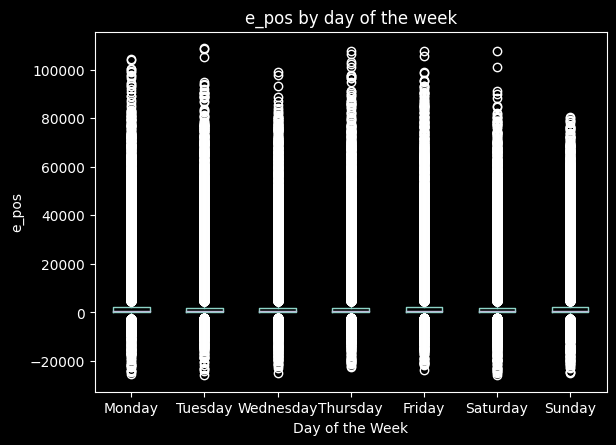

In [80]:
# Create a boxplot of e_pos_neg_sum grouped by the day of the week
e_pos_cols = [col for col in df.columns if 'e_pos' in col]

plt.figure(figsize=(15, 6))
df.boxplot(column=e_pos_cols, by='day_of_week', grid=False)
plt.xlabel('Day of the Week')
plt.ylabel('e_pos')
plt.title('e_pos by day of the week')
plt.xticks(ticks=range(1, 8), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.suptitle('')  
plt.show()

<Figure size 1500x600 with 0 Axes>

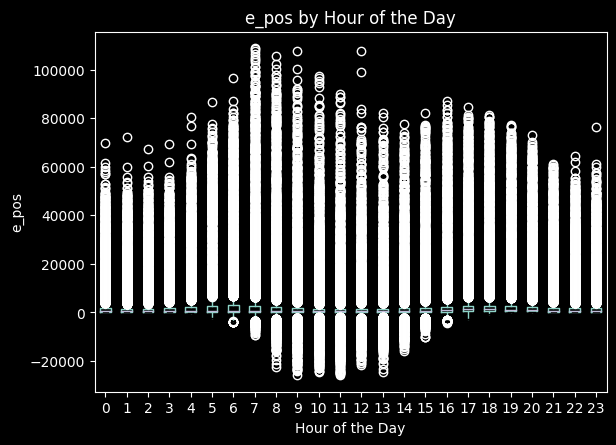

In [81]:
# Create a boxplot of e_pos_neg_sum grouped by the hour of the day
e_pos_cols = [col for col in df.columns if 'e_pos' in col]

plt.figure(figsize=(15, 6))
df.boxplot(column=e_pos_cols, by='hour', grid=False)
plt.xlabel('Hour of the Day')
plt.ylabel('e_pos')
plt.title('e_pos by Hour of the Day')
plt.suptitle('')  
plt.show()

## Add mean energy consumption over all the stations

In [82]:
# Add a new column with the mean of the stations' values to perform stationarity and other checks
e_pos_neg_cols = [col for col in df_nc.columns if 'e_pos_neg_sum' in col]
df_nc['mean_e_pos_neg_sum'] = df_nc[e_pos_neg_cols].mean(axis=1)

# Data Exploration after cleaning

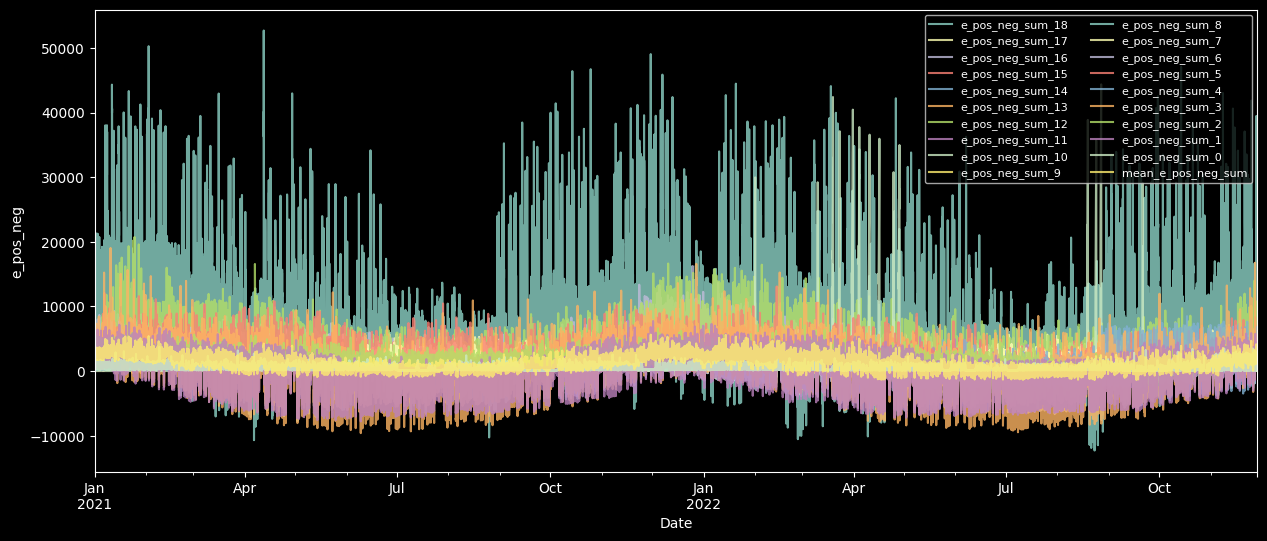

In [83]:
# Set the 'Date' column as the index of the DataFrame
df_nc.set_index('Date', inplace=True)

# Plot the e_pos_neg_N measures in the df_nc dataset
e_pos_neg_cols = [col for col in df_nc.columns if 'e_pos_neg' in col]

# Plot the e_pos_neg_N columns against the DataFrame's index (which is now the 'Date' column)
df_nc[e_pos_neg_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Date')  # Update the x-axis label
plt.ylabel('e_pos_neg')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

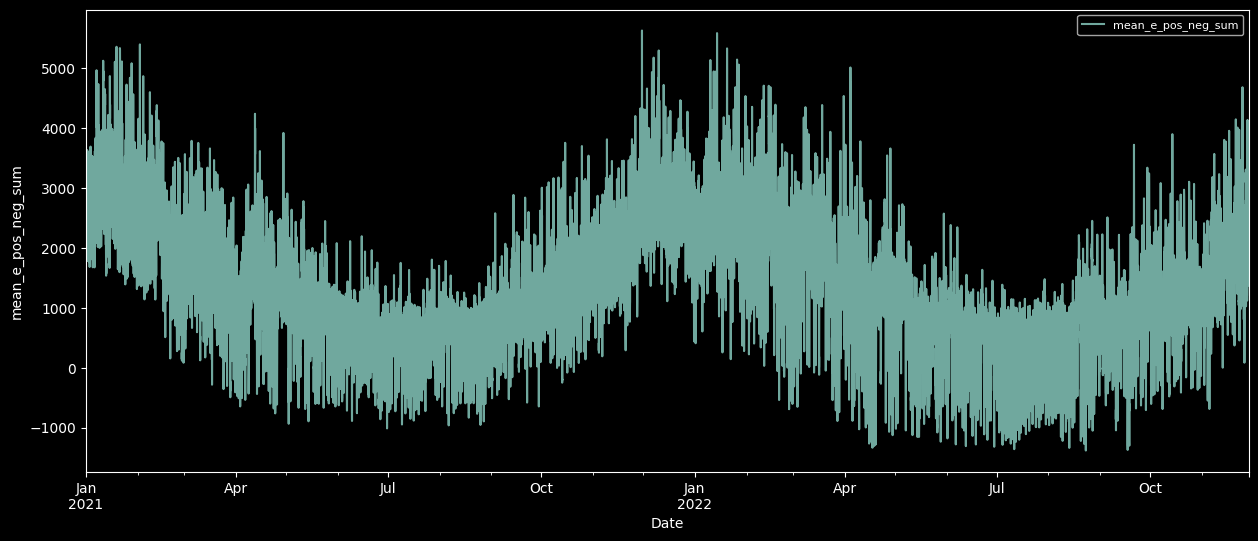

In [84]:
# Plot the mean_e_pos_neg_sum column against the DataFrame's index (which is now the 'Date' column)
df_nc['mean_e_pos_neg_sum'].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Date')  # Update the x-axis label
plt.ylabel('mean_e_pos_neg_sum')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

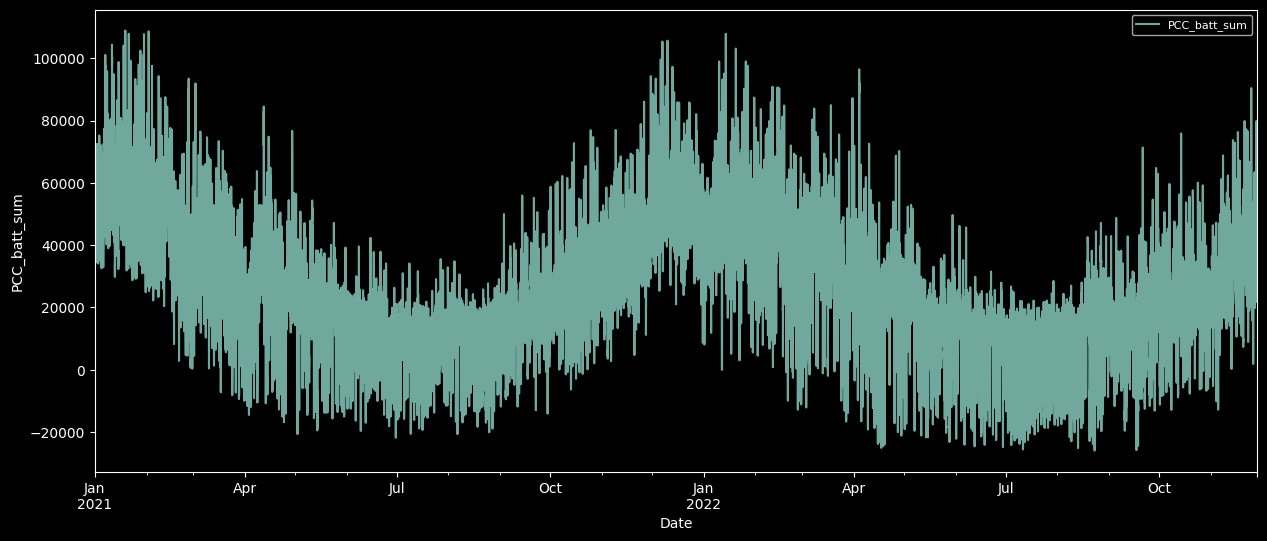

In [85]:
# Plot the PCC_batt_sum column against the DataFrame's index (which is now the 'Date' column)
df_nc['PCC_batt_sum'].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Date')  # Update the x-axis label
plt.ylabel('PCC_batt_sum')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

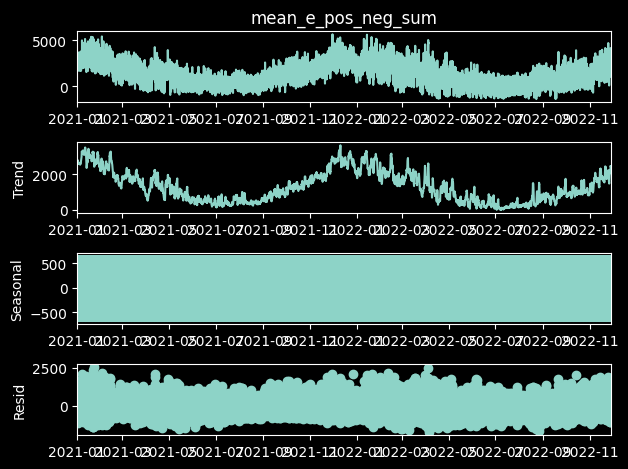

In [86]:
# Decompose the time series of mean_e_pos_neg_sum into trend, seasonality, and residual components
seasonal_period=24
result = seasonal_decompose(df_nc['mean_e_pos_neg_sum'], model='additive', period=seasonal_period) 
result.plot() 
plt.show()

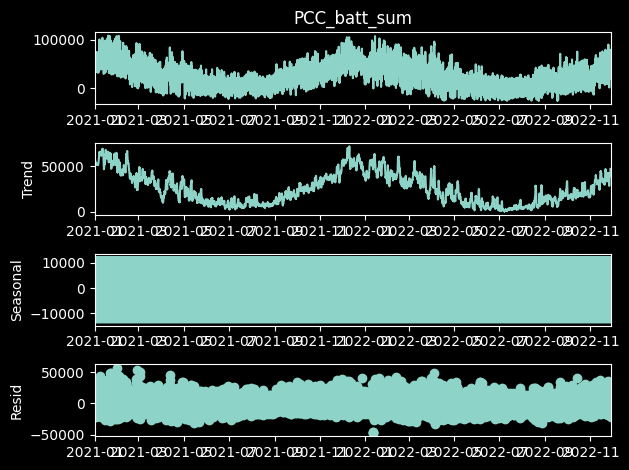

In [87]:
# Decompose the time series of PCC_batt_sum into trend, seasonality, and residual components
result = seasonal_decompose(df_nc['PCC_batt_sum'], model='additive', period=seasonal_period)
result.plot()
plt.show()

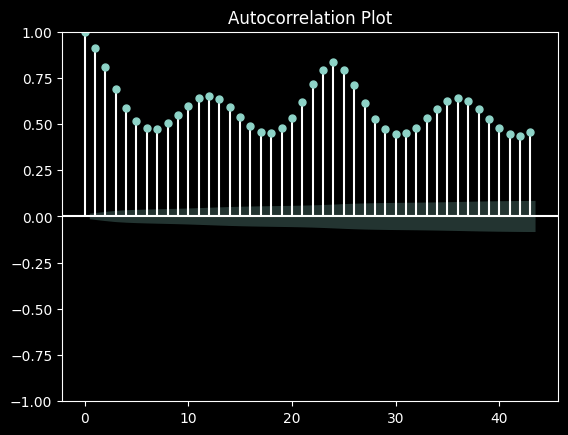

In [88]:
# Plot the autocorrelation function of mean_e_pos_neg_sum
plot_acf(df_nc['mean_e_pos_neg_sum'])
plt.title('Autocorrelation Plot')
plt.show()

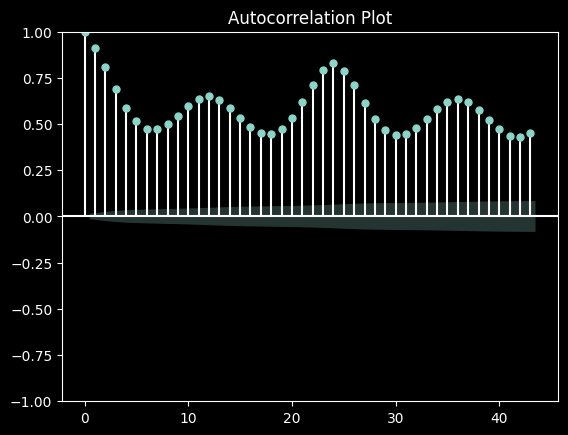

In [89]:
# Plot the autocorrelation function of PCC_batt_sum
plot_acf(df_nc['PCC_batt_sum'])
plt.title('Autocorrelation Plot')
plt.show()

In [90]:
# Perform the Augmented Dickey-Fuller test for stationarity on mean_e_pos_neg_sum
adf_test = sm.tsa.adfuller(df_nc['mean_e_pos_neg_sum'])
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print('Critical Values:', adf_test[4])

# The ADF statistic value of -4.1671377205629 is more negative than the critical values, indicating a strong rejection of the null hypothesis.
#The p-value of 0.0007485726703005352 is very small, providing strong evidence against the null hypothesis.
#Since the ADF statistic is more negative than the critical values and the p-value is small, we can conclude that the time series is stationary at a high confidence level.

# We are not convinced by these results. these functions seem to result often stationarity.

ADF Statistic: -4.1671377205629
p-value: 0.0007485726703005352
Critical Values: {'1%': -3.4307420576980996, '5%': -2.861713273825104, '10%': -2.566862229252193}


In [91]:
# Perform the Augmented Dickey-Fuller test for stationarity on PCC_batt_sum
adf_test = sm.tsa.adfuller(df_nc['PCC_batt_sum'])
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print('Critical Values:', adf_test[4])

ADF Statistic: -4.2309728557623885
p-value: 0.0005837165514240897
Critical Values: {'1%': -3.4307420576980996, '5%': -2.861713273825104, '10%': -2.566862229252193}


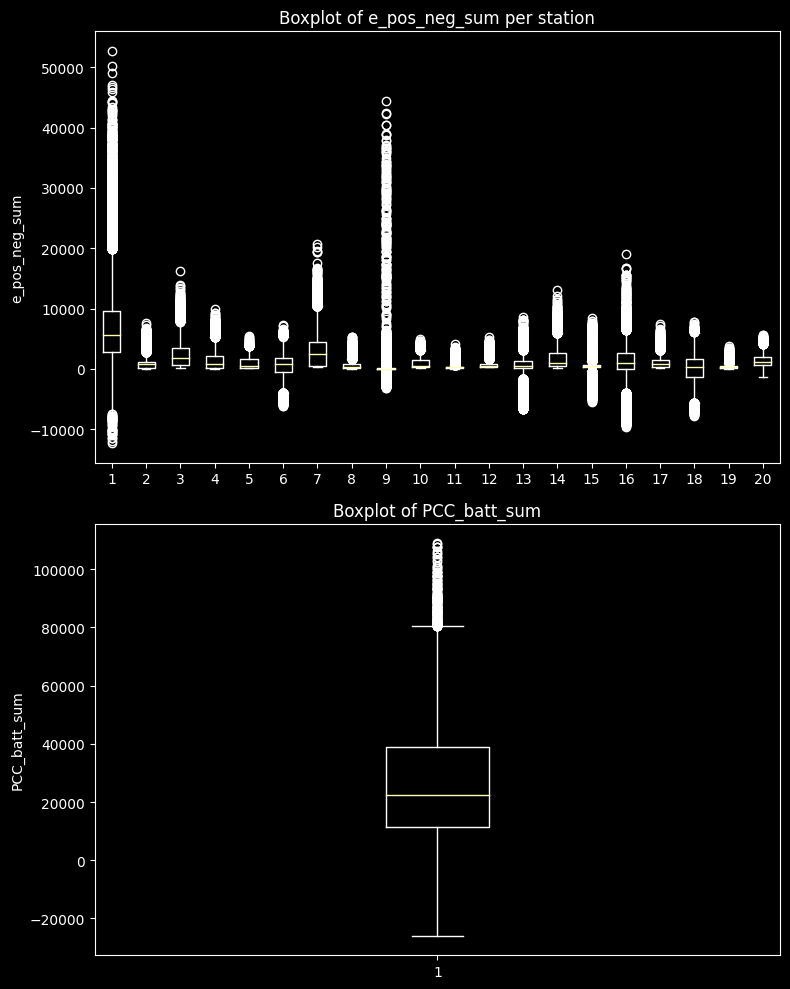

In [92]:
# Plot some boxplots of the target features
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# Create a boxplot for mean_e_pos_neg_sum
axes[0].boxplot(df_nc[e_pos_neg_cols])
axes[0].set_ylabel('e_pos_neg_sum')
axes[0].set_title('Boxplot of e_pos_neg_sum per station')

# Create a boxplot for PCC_batt_sum
axes[1].boxplot(df_nc['PCC_batt_sum'])
axes[1].set_ylabel('PCC_batt_sum')
axes[1].set_title('Boxplot of PCC_batt_sum')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

## Split the dataset into training and testing sets

### Concatenated dataset

In [93]:
# Get the date corresposnding to the 80% position of the dataset
n_samples = df.shape[0]/19
train_ratio = 0.8
perc80_sample_idx = int(n_samples*train_ratio)
date_perc80 = df['Date'][perc80_sample_idx]

In [94]:
# Train test split
df_tr, df_te = df.loc[df['Date'] < pd.to_datetime(date_perc80)], df.loc[df['Date'] >= pd.to_datetime(date_perc80)]

In [95]:
df_tr.head(3)

,Date,station_id,e_pos_neg_sum,loss_meters,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed,...,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity,day_of_week,day_of_year,year,month,day,hour
0,2021-01-01 00:00:00+00:00,0,485.0,-50.581219,945.905722,0.788833,-0.375317,0.0,66.748611,0.652444,...,100.0,100.0,99.0,100.0,4,1,2021,1,1,0
1,2021-01-01 01:00:00+00:00,0,218.0,766.563622,946.249667,0.791278,-0.553497,0.0,63.983167,0.549056,...,100.0,99.0,100.0,100.0,4,1,2021,1,1,1
2,2021-01-01 02:00:00+00:00,0,224.0,460.000000,946.063833,0.608611,-0.514245,0.0,65.924611,0.501333,...,99.0,100.0,100.0,100.0,4,1,2021,1,1,2


In [96]:
df_te.head(3)

,Date,station_id,e_pos_neg_sum,loss_meters,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed,...,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity,day_of_week,day_of_year,year,month,day,hour
14085,2022-08-10 21:00:00+00:00,0,265.0,293.0,958.101944,21.003056,-0.863087,0.000000,53.325778,0.0,...,42.0,48.0,53.0,56.0,2,222,2022,8,10,21
14086,2022-08-10 22:00:00+00:00,0,176.0,409.0,958.447889,20.919278,-0.878270,0.000000,54.349167,0.0,...,48.0,53.0,56.0,58.0,2,222,2022,8,10,22
14087,2022-08-10 23:00:00+00:00,0,159.0,440.0,958.748611,19.241778,-2.507111,0.000239,68.249556,0.0,...,53.0,56.0,58.0,59.0,2,222,2022,8,10,23


In [97]:
# df_tr and df_te are overwritten by the ones form the non-concatenated dataset as they are not used

### Non-concatenated dataset

In [98]:
# Rename PCC_batt_sum to e_pos_neg_sum_20 in df_nc for ease of use
df_nc = df_nc.rename(columns={'PCC_batt_sum': 'e_pos_neg_sum_19'})

In [99]:
# Do the same on the df_nc dataset
date_perc80 = df_nc.index[perc80_sample_idx]

In [100]:
# Train test split
df_tr, df_te = df_nc.loc[df_nc.index < pd.to_datetime(date_perc80)], df_nc.loc[df_nc.index >= pd.to_datetime(date_perc80)]

## Perform outlier detection

In [101]:
# Use a moving average method for outlier detection as the targets have seasonality
# We perform outlier detection on all the features in the training dataset as it doesn't seem to be too long to be done

def outlier_detection(df_tr):
    #df_tr.set_index('Date', inplace=True)
    #df_te.set_index('Date', inplace=True)
    
    df_tr = df_tr.astype(float)
    window_size = 15  # Set the window size for the moving average
    moving_avg_df = df_tr.rolling(window=window_size).mean()  # Calculate the moving average for each column
    std_dev_df = df_tr.rolling(window=window_size).std()  # Calculate the standard deviation for each column
    threshold = 2  # Define the threshold for outlier detection

    outliers_df_train = pd.DataFrame(index=df_tr.index, columns=df_tr.columns) 
    capped_df_train = df_tr.copy()

    for column in df_tr.columns:
        # Calculate the upper and lower bounds for outlier detection
        upper_bound = moving_avg_df[column] + threshold * std_dev_df[column]
        lower_bound = moving_avg_df[column] - threshold * std_dev_df[column]

        # Find outliers by comparing values to the bounds
        outliers = (df_tr[column] > upper_bound) | (df_tr[column] < lower_bound)

        # Store outlier information in the outliers DataFrame
        outliers_df_train[column] = outliers

        # Cap outliers to the mean value within the window
        mean_value = df_tr[column].rolling(window=window_size).mean()
        capped_df_train[column] = np.where(outliers, mean_value, capped_df_train[column])
    return capped_df_train

capped_df_train = outlier_detection(df_tr)

In [102]:
# Check maximum and minimum values in df_train before outlier detection
print('maximum values:\n', df_tr.max())
print('-'*20)
print('minimum values:\n', df_tr.min())

maximum values:
 e_pos_neg_sum_18          52685.0
e_pos_neg_sum_17           7609.0
e_pos_neg_sum_16          16243.0
e_pos_neg_sum_15      9994.028333
e_pos_neg_sum_14           5385.0
                         ...     
year                         2022
month                          12
day                            31
hour                           23
mean_e_pos_neg_sum     5631.77307
Length: 106, dtype: object
--------------------
minimum values:
 e_pos_neg_sum_18         -10696.0
e_pos_neg_sum_17              0.0
e_pos_neg_sum_16            130.0
e_pos_neg_sum_15             44.0
e_pos_neg_sum_14             92.0
                         ...     
year                         2021
month                           1
day                             1
hour                            0
mean_e_pos_neg_sum   -1361.789474
Length: 106, dtype: object


In [103]:
# Check maximum and minimum values in df_train after outlier detection
print('maximum values:\n', capped_df_train.max())
print('-'*20)
print('minimum values:\n', capped_df_train.min())

maximum values:
 e_pos_neg_sum_18      40722.000000
e_pos_neg_sum_17       6580.000000
e_pos_neg_sum_16      12938.000000
e_pos_neg_sum_15       8993.421667
e_pos_neg_sum_14       4647.000000
                          ...     
year                   2022.000000
month                    12.000000
day                      31.000000
hour                     23.000000
mean_e_pos_neg_sum     5313.052632
Length: 106, dtype: float64
--------------------
minimum values:
 e_pos_neg_sum_18     -10541.000000
e_pos_neg_sum_17          0.000000
e_pos_neg_sum_16        130.000000
e_pos_neg_sum_15         44.000000
e_pos_neg_sum_14         92.000000
                          ...     
year                   2021.000000
month                     1.000000
day                       1.000000
hour                      0.000000
mean_e_pos_neg_sum    -1361.789474
Length: 106, dtype: float64


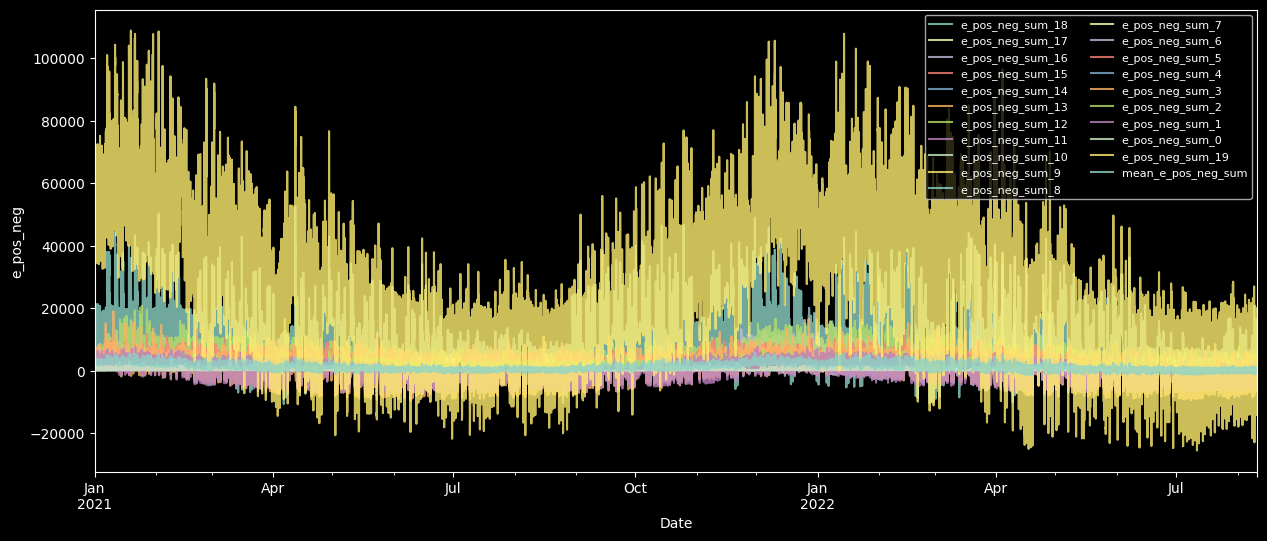

In [104]:
# Visualize target features before outlier detection
# Plot the e_pos_neg_N measures in the df_tr dataset
e_pos_neg_cols = [col for col in df_tr.columns if 'e_pos_neg' in col]

# Plot the e_pos_neg_N columns against the DataFrame's index (which is now the 'Date' column)
df_tr[e_pos_neg_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Date')  # Update the x-axis label
plt.ylabel('e_pos_neg')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

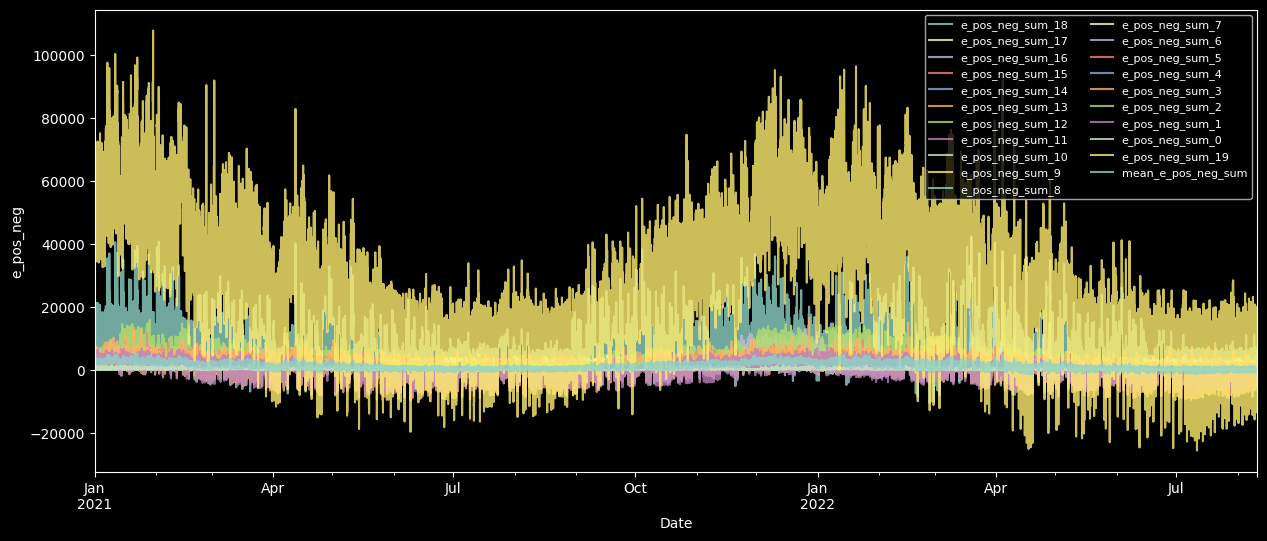

In [105]:
# Visualize target features after outlier detection
# Plot the e_pos_neg_N measures in the capped_df_tr dataset
e_pos_neg_cols = [col for col in capped_df_train.columns if 'e_pos_neg' in col]

# Plot the e_pos_neg_N columns against the DataFrame's index (which is now the 'Date' column)
capped_df_train[e_pos_neg_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Date')  # Update the x-axis label
plt.ylabel('e_pos_neg')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

In [106]:
# Assigned the cleaned version of df_train
df_train = capped_df_train

## Normalize the data

In [107]:
target_features = [str(f'e_pos_neg_sum_{i}') for i in range(20)]

# Scale the train_data (except the target features)
scaler = MinMaxScaler(feature_range=(0, 1))
df_ncs_tr_features = scaler.fit_transform(df_tr.drop(columns=target_features, axis=1))

# Scale the test_data (except the target features)
df_ncs_te_features = scaler.transform(df_te.drop(columns=target_features, axis=1))

# Define a scaler for the target features for being able to reverse the operation later
label_scaler = MinMaxScaler(feature_range=(0, 1))
df_ncs_tr_labels = label_scaler.fit_transform(df_tr[target_features])

# Scale the test_data (except the target features)
df_ncs_te_labels = label_scaler.transform(df_te[target_features])

# Models building

##  Naive Forecaster

In [108]:
# Get the date corresponding to the 80% position of the dataset
n_samples = df_nc.shape[0]
train_ratio = 0.8
perc80_sample_idx = int(n_samples*train_ratio)
date_perc80 = df_nc.index[perc80_sample_idx]

# Train test split
df_tr, df_te = df_nc.loc[df_nc.index < pd.to_datetime(date_perc80)], df_nc.loc[df_nc.index >= pd.to_datetime(date_perc80)]

In [109]:
def naive_forecaster(df_train, station_id=0, steps_ahead=24):
    last_value = df_train[f'e_pos_neg_sum_{station_id}'].iloc[-1]
    predictions = [last_value] * steps_ahead
    df_train = df_train.reset_index()
    last_date = pd.to_datetime(df_train.Date.iloc[-1])
    dates = pd.date_range(start=last_date + pd.DateOffset(hours=1), periods=steps_ahead, freq='H')

    data = {'Date': dates, f'e_pos_neg_sum_{station_id}': predictions}
    data = pd.DataFrame(data)
    return data

In [110]:
station_id = 0
preds_naive = naive_forecaster(df_tr, station_id, 24)
preds_naive.head(3)

,Date,e_pos_neg_sum_0
0,2022-07-12 13:00:00+00:00,380.0
1,2022-07-12 14:00:00+00:00,380.0
2,2022-07-12 15:00:00+00:00,380.0


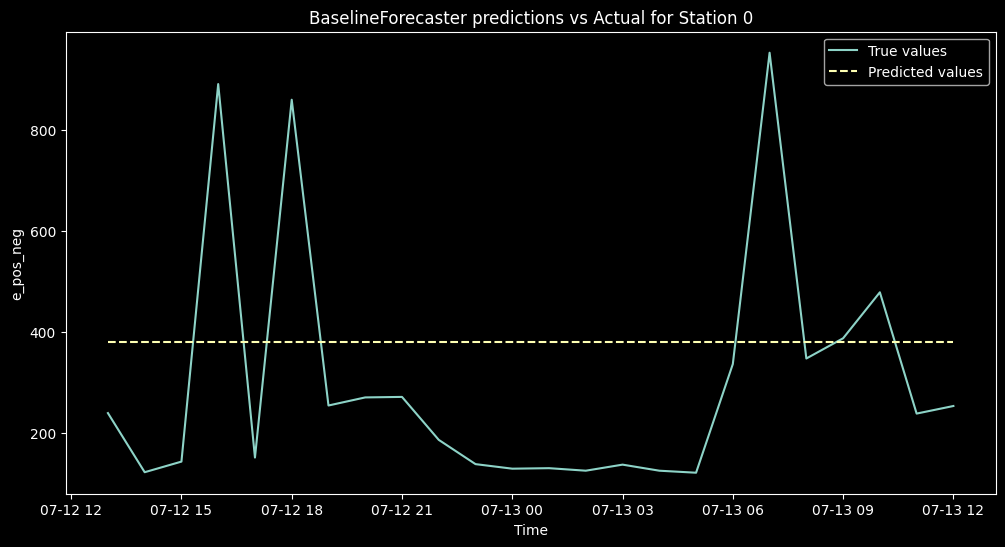

In [111]:
# Plot the predictions of the naive forecaster
plt.figure(figsize=(12, 6))
plt.plot(df_te[:24].index, df_te[f'e_pos_neg_sum_{station_id}'][:24], label='True values')
plt.plot(preds_naive.Date, preds_naive[f'e_pos_neg_sum_{station_id}'], label='Predicted values', linestyle='--')
plt.xlabel('Time')
plt.ylabel('e_pos_neg')
plt.legend()
plt.title(f'BaselineForecaster predictions vs Actual for Station {station_id}')
plt.show()

In [112]:
# compute scores for the naive Forecaster
nmae = lambda y, y_hat: np.sum(np.abs(y_hat-y), axis=0)/np.sum(np.abs(y), axis=0)

naive_scores = [mean_squared_error(df_te[f'e_pos_neg_sum_{station_id}'][:24], preds_naive[f'e_pos_neg_sum_{station_id}'], squared=False), 
                r2_score(df_te[f'e_pos_neg_sum_{station_id}'][:24], preds_naive[f'e_pos_neg_sum_{station_id}']), 
                nmae(df_te[f'e_pos_neg_sum_{station_id}'][:24], preds_naive[f'e_pos_neg_sum_{station_id}'])]

print('RMSE:', naive_scores[0], '\n',
     'R2:', naive_scores[1], '\n',
     'NMAE:', naive_scores[2])

RMSE: 256.1603501715283 
 R2: -0.09547975954308496 
 NMAE: 0.0


## Check the data format

In [113]:
# Make sure both the datasets have Date as index
df.set_index('Date', inplace=True)

# Make sure all the features have float values
df = df.astype(float)
df_nc = df_nc.astype(float)

In [114]:
df.columns

Index(['station_id', 'e_pos_neg_sum', 'loss_meters', 'AirPressure',
       'AirTemp_Avg', 'PyrIrradiance_Avg', 'Ramount_Tot', 'RelHumidity',
       'WindSpeed', '0_ghi_backwards', '1_ghi_backwards', '2_ghi_backwards',
       '3_ghi_backwards', '4_ghi_backwards', '5_ghi_backwards',
       '6_ghi_backwards', '7_ghi_backwards', '8_ghi_backwards',
       '9_ghi_backwards', '10_ghi_backwards', '11_ghi_backwards',
       '12_ghi_backwards', '13_ghi_backwards', '14_ghi_backwards',
       '15_ghi_backwards', '16_ghi_backwards', '17_ghi_backwards',
       '18_ghi_backwards', '19_ghi_backwards', '20_ghi_backwards',
       '21_ghi_backwards', '22_ghi_backwards', '23_ghi_backwards',
       '0_temperature', '1_temperature', '2_temperature', '3_temperature',
       '4_temperature', '5_temperature', '6_temperature', '7_temperature',
       '8_temperature', '9_temperature', '10_temperature', '11_temperature',
       '12_temperature', '13_temperature', '14_temperature', '15_temperature',
       '16_tem

In [115]:
df_nc.columns

Index(['e_pos_neg_sum_18', 'e_pos_neg_sum_17', 'e_pos_neg_sum_16',
       'e_pos_neg_sum_15', 'e_pos_neg_sum_14', 'e_pos_neg_sum_13',
       'e_pos_neg_sum_12', 'e_pos_neg_sum_11', 'e_pos_neg_sum_10',
       'e_pos_neg_sum_9',
       ...
       '21_relativehumidity', '22_relativehumidity', '23_relativehumidity',
       'day_of_week', 'day_of_year', 'year', 'month', 'day', 'hour',
       'mean_e_pos_neg_sum'],
      dtype='object', length=106)

## Univariate Linear Forecaster

In [116]:
# Define the LinearForecaster model
class LinearForecaster:
    def __init__(self):
        self.theta = None
        self.target_cols = None

    def fit(self, X, y):
        self.target_cols = y.columns
        self.theta = np.linalg.pinv(X.values.T@X.values)@(X.values.T@y.values)
        return self
    
    def predict(self, X):
        preds = X.values @ self.theta
        return pd.DataFrame(preds, index=X.index, columns=self.target_cols)   

In [117]:
def get_hankel(df, embedding=3):
    dfs = {}
    for c in df.columns:
        df_i = pd.concat([df[[c]].shift(-l) for l in range(embedding)], axis=1).iloc[:-embedding]
        df_i.columns = [i for i in range(df_i.shape[1])]
        dfs[c] = df_i
    return pd.concat(dfs, axis=1)

In [118]:
# Compute training and testing sets

train_period = 24*5  # Train on 5 days
tr_ratio = 0.75
n_stations = 19+1 # 19 stations + 1 for the sum of all stations

forecast_periods = [train_period-i for i in range(1, 25)]
period_name = ['1h', '2h', '3h', '4h', '5h', '6h', '7h', '8h', '9h', '10h', '11h', '12h', '13h', '14h', '15h', '16h', '17h', '18h', '19h', '20h', '21h', '22h', '23h', '24h']

train_test_splits = {}
linear_univariate_ds = np.ndarray(n_stations, dtype=object)

for i in range(n_stations):
    df_l = pd.DataFrame(df_nc[f'e_pos_neg_sum_{i}'])
    for f_period_name, forecast_period in zip(period_name, forecast_periods):
        df_emb = get_hankel(df_l, embedding = train_period)
        x = df_emb.loc[:, df_emb.columns.get_level_values(1) < forecast_period]
        y = df_emb.loc[:, df_emb.columns.get_level_values(1) >= forecast_period]

        n_tr = int(len(x) * tr_ratio)
        X_train, X_test = x.iloc[:n_tr, :], x.iloc[n_tr:, :]
        y_train, y_test = y.iloc[:n_tr, :], y.iloc[n_tr:, :]

        train_test_splits[f'{f_period_name}'] = [X_train, y_train, X_test, y_test]
    linear_univariate_ds[i] = train_test_splits

In [119]:
# Train multiple Linear regresssion models on the different datasets, and save results

nmae = lambda y, y_hat: np.sum(np.abs(y_hat-y), axis=0)/np.sum(np.abs(y), axis=0)

scores = {}
linear_univariate_scores = np.ndarray(n_stations, dtype=object)

for i in range(n_stations):
    train_test_splits = linear_univariate_ds[i]
    for split_name, train_test in train_test_splits.items():
        # Train a linear regression model
        lr = LinearForecaster()
        lr.fit(train_test[0], train_test[1])
        y_train_pred_lr = lr.predict(train_test[0])
        y_test_pred_lr = lr.predict(train_test[2])

        # List of scores, in order: [RMSE, R2, NMAE]
        score_string = f'Linear {split_name}'

        scores[score_string] = [mean_squared_error(train_test[3], y_test_pred_lr, squared=False), 
                                            r2_score(train_test[3], y_test_pred_lr), nmae(train_test[3], y_test_pred_lr).mean()]

        # Print results for the different models
        # print(f'Station {i}, {split_name} scores:')
        # print(f'Training RMSE: {mean_squared_error(train_test[1], y_train_pred_lr, squared=False):.2f}')
        # print(f'Testing RMSE: {scores[f"{score_string}"][0]:.2f}')
        # print(f'Training R2: {r2_score(train_test[1], y_train_pred_lr):.2f}')
        # print(f'Testing R2: {scores[f"{score_string}"][1]:.2f}')
        # print(f'Training mean NMAE: {nmae(train_test[1], y_train_pred_lr).mean():0.2e}')
        # print('Testing mean NMAE: {:0.2e}'.format(nmae(train_test[3], y_test_pred_lr).mean()))
        # print('-'*50, '\n')
    linear_univariate_scores[i] = scores # The score for the PCC is the last one in the list

## Multivariate Linear Forecaster

In [120]:
df_m = df_nc.copy()

# Compute training and testing sets

train_period = 24*5  # Train on 5 days
tr_ratio = 0.75
n_stations = 19+1 # 19 stations + 1 for the sum of all stations

train_test_splits = {}
linear_multivariate_ds = np.ndarray(n_stations, dtype=object)

# for i in range(n_stations):
#     print(i)
#     for f_period_name, forecast_period in zip(period_name, forecast_periods):
#         df_emb = get_hankel(df_m, embedding = train_period)

#         x = df_emb.loc[:, df_emb.columns.get_level_values(1) < forecast_period]
#         x["dayminute"] = np.sin((x.index.hour * 60 + x.index.minute) / (1410) * 2 * np.pi - np.pi)/2
#         x["dayofyear"] = x.index.dayofyear / 365

#         y = df_emb.loc[:, df_emb.columns.get_level_values(1) >= forecast_period][f'e_pos_neg_sum_{i}']

#         n_tr = int(len(x) * tr_ratio)
#         X_train, X_test = x.iloc[:n_tr, :], x.iloc[n_tr:, :]
#         y_train, y_test = y.iloc[:n_tr, :], y.iloc[n_tr:, :]

#         train_test_splits[f'{f_period_name}'] = [X_train, y_train, X_test, y_test]
#     linear_multivariate_ds[i] = train_test_splits

In [121]:
# Train multivariate Linear regression model on the stations
scores = {}
linear_multivariate_models = np.ndarray((n_stations,24), dtype=object)
linear_multivariate_scores = np.ndarray(n_stations, dtype=object)

# for i in range(n_stations):
#     train_test_splits = linear_univariate_ds[i]
#     h = 0
#     for split_name, train_test in train_test_splits.items():
#         # Train a linear regression model
#         lr = LinearForecaster()
#         lr.fit(train_test[0], train_test[1])
#         y_train_pred_lr = lr.predict(train_test[0])
#         y_test_pred_lr = lr.predict(train_test[2])

#         linear_multivariate_models[i, h] = lr
#         h += 1

#         # List of scores, in order: [RMSE, R2, NMAE]
#         score_string = f'Linear {split_name}'

#         scores[score_string] = [mean_squared_error(train_test[3], y_test_pred_lr, squared=False), 
#                                             r2_score(train_test[3], y_test_pred_lr), nmae(train_test[3], y_test_pred_lr).mean()]

#         # Print results for the different models
#         print(f'Station {i}, {split_name} scores:')
#         print(f'Training RMSE: {mean_squared_error(train_test[1], y_train_pred_lr, squared=False):.2f}')
#         print(f'Testing RMSE: {scores[f"{score_string}"][0]:.2f}')
#         print(f'Training R2: {r2_score(train_test[1], y_train_pred_lr):.2f}')
#         print(f'Testing R2: {scores[f"{score_string}"][1]:.2f}')
#         print(f'Training mean NMAE: {nmae(train_test[1], y_train_pred_lr).mean():0.2e}')
#         print('Testing mean NMAE: {:0.2e}'.format(nmae(train_test[3], y_test_pred_lr).mean()))
#         print('-'*50, '\n')
#     linear_multivariate_scores[i] = scores # The score for the PCC is the last one in the list

In [122]:
# for i in range(n_stations):
#     with open(Path(data_path, f'linear_multi_models\lm_{i}.pkl'), 'wb') as handle:
#         pickle.dump(linear_multivariate_models[i,:], handle, protocol=pickle.HIGHEST_PROTOCOL)


# with open(Path(data_path, f'lm_scores.pkl'), 'wb') as handle:
#     pickle.dump(linear_multivariate_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [123]:
# Load the pre-trained models as it takes a lot of time to train them
for i in range(n_stations):
    # Load data
    with open(Path(data_path, f'linear_multi_models/lm_{i}.pkl'), 'rb') as handle:
        linear_multivariate_models[i,:] = pickle.load(handle)


# Load the scores of the pre-trained models
with open(Path(data_path, f'lm_scores.pkl'), 'rb') as handle:
    linear_multivariate_scores = pickle.load(handle)

## Stats Forecast models (AutoARIMA, AutoETS, MSTL)

In [124]:
# Get the date corresposnding to the 80% position of the dataset
df_a = df.copy()
df_a.reset_index(inplace=True)

df_a.rename(columns={'Date': 'ds'}, inplace=True)
df_a.rename(columns={'station_id': 'unique_id'}, inplace=True)
df_a.rename(columns={'e_pos_neg_sum': 'y'}, inplace=True)

df_a['unique_id'] = df_a['unique_id'].astype(int).astype(object)

In [125]:
n_samples = df_a.shape[0]/20
tr_ratio = 0.8
perc80_sample_idx = int(n_samples*tr_ratio)
date_perc80 = df_a['ds'][perc80_sample_idx]


# Train test split
df_tr, df_te = df_a.loc[df_a['ds'] < pd.to_datetime(date_perc80)], df_a.loc[df_a['ds'] >= pd.to_datetime(date_perc80)]

In [126]:
# Reduce the size of the training set
n_samples = df_tr.shape[0]/20
ratio = 0.8
idx = int(n_samples*ratio)
date_perc = df_tr['ds'][idx]
_, df_tr = df_tr.loc[df_tr['ds'] < pd.to_datetime(date_perc)], df_tr.loc[df_tr['ds'] >= pd.to_datetime(date_perc)]

df_tr.reset_index(inplace=True, drop=True)
df_te.reset_index(inplace=True, drop=True)

In [127]:
# Standardize features for the model
n_series = 20

# Rename the PCC station
df_tr.loc[df_tr['unique_id'] == 19, 'unique_id'] = 'PCC'
df_te.loc[df_te['unique_id'] == 19, 'unique_id'] = 'PCC'

# Get the unique ids
uids = df_tr['unique_id'].unique()[:n_series]

# Get the data for the selected stations
df_tr = df_tr.query('unique_id in @uids')
df_te = df_te.query('unique_id in @uids')

y_destandardized = {}

# standardize data in df_tr and df_te
for column in df_tr.drop(columns = ['ds', 'unique_id', 'day_of_week', 'day_of_year', 'year', 'month', 'day', 'hour']).columns:
    stds = {uid: df_tr.query('unique_id == @uid')[column].std() for uid in uids}
    means = {uid: df_tr.query('unique_id == @uid')[column].mean() for uid in uids}

    for uid in uids:
        y = (df_tr.loc[df_tr['unique_id'] == uid, column] - means[uid])/stds[uid]
        
        # Save the destandardized values
        if column == 'y':
            y_destandardized[uid] = y

        df_tr.loc[df_tr['unique_id'] == uid, column] = y - y.min()
        df_te.loc[df_te['unique_id'] == uid, column] = (df_te.loc[df_te['unique_id'] == uid, column] - means[uid])/stds[uid]- y.min()

<AxesSubplot: xlabel='ds'>

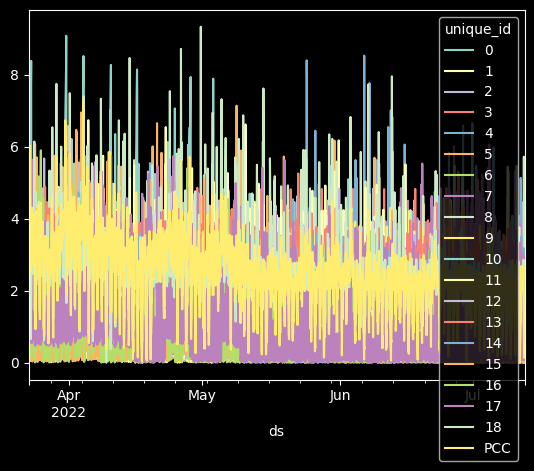

In [128]:
df_tr.reset_index(drop=True).pivot(columns='unique_id', values='y', index='ds').plot()

In [129]:
df_dummy_tr = df_tr.query('unique_id == 0').copy()
df_dummy_te = df_te.query('unique_id == 0').copy()

<AxesSubplot: xlabel='ds'>

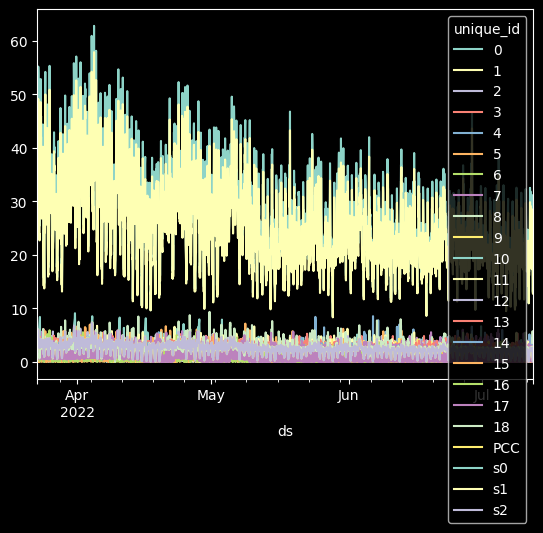

In [130]:
# create aggregations from the bottom time series
groups = {  's0':uids,
            's1':uids[:-1],
            's2': uids[-1:]
          }

for name, g in groups.items():
    df_dummy_tr['unique_id'] = name
    df_dummy_te['unique_id'] = name
    df_dummy_tr['y'] = df_tr.query('unique_id in @g').pivot(columns='unique_id', values='y', index='ds').sum(axis=1).reset_index(drop=True)
    df_tr = pd.concat([df_tr, df_dummy_tr], axis=0)
    df_dummy_te['y'] = df_te.query('unique_id in @g').pivot(columns='unique_id', values='y', index='ds').sum(axis=1).reset_index(drop=True)
    df_te = pd.concat([df_te, df_dummy_te], axis=0)

df_tr.reset_index(drop=True).pivot(columns='unique_id', values='y', index='ds').plot()

In [ ]:
# Here you can choose how many steps ahead you want to forecast
horizon = 24
# level = [80, 90]

# Create a df where to store forecasts
df_hat = df_te[['unique_id', 'ds', 'y']].copy()
df_hat['y'] = 0

# Extract dates for train and test set 
dates = df_hat['ds'].unique()
d = dates[:horizon]

df_hat = df_hat.query('ds in @d')

# Exogenous variables
exog_tr = df_tr.loc[:, ~df_tr.columns.isin(['y'])]  # Add any other exogenous variables here
exog_te = df_te.loc[:, ~df_te.columns.isin(['y'])]  # Add any other exogenous variables here

models = [AutoETS(season_length = 24), AutoARIMA(season_length = 24, approximation=True), MSTL(season_length=[24, 24 * 7], trend_forecaster=AutoARIMA())]

sf = StatsForecast(
    models = models,
    freq = 'H', n_jobs=-1
)

# Fit a separate model for each TS
for uid in tqdm(df_tr['unique_id'].unique()):
# for uid in tqdm([0, 1, 19]):
    # Prepare the exogenous variables
    exog_train = exog_tr.query('unique_id == @uid')
    exog_test = exog_te.query('unique_id == @uid')

    sf.fit(df_tr.query('unique_id == @uid'))
    y_hat = sf.predict(h=horizon, X_df=exog_test.iloc[:horizon,:])
    
    # Forecast 24 time steps ahead
    df_hat.loc[df_hat['unique_id'] == uid, 'y_ets'] = y_hat.reset_index(drop=True)['AutoETS'].values
    df_hat.loc[df_hat['unique_id'] == uid, 'y_arima'] = y_hat.reset_index(drop=True)['AutoARIMA'].values
    df_hat.loc[df_hat['unique_id'] == uid, 'y_mstl'] = y_hat.reset_index(drop=True)['MSTL'].values

 43%|█████████████████████████████████▍                                           | 10/23 [1:58:42<2:55:15, 808.87s/it]

In [ ]:
# Plot forecasts and actual signals, we are using the ETS forecasts as an example
fig, ax = plt.subplots(12, 2, figsize=(24, 20))
for uid, a in zip(df_te['unique_id'].unique(), ax.ravel()):
    y_te = df_te.loc[df_te['unique_id'] == uid, 'y'].reset_index(drop=True)
    y_hat_s = df_hat.loc[df_hat['unique_id'] == uid, 'y_ets'].reset_index(drop=True)
    y_te.iloc[:horizon].plot(ax=a)
    y_hat_s.iloc[:horizon].plot(ax=a)

### Hierarchical Reconciliation

In [ ]:
y_hat = df_hat.pivot(columns='unique_id', values='y_ets', index='ds')
y_hat = y_hat[np.hstack([['s0', 's1', 's2'], uids])]
y_test = df_te.pivot(columns='unique_id', values='y', index='ds')
y_test = y_test[np.hstack([['s0', 's1', 's2'], uids])]
y_test = y_test.iloc[:horizon,:]

In [ ]:
agg_matrix = np.vstack([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 
                        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])
s_matrix = np.vstack([agg_matrix, np.eye(len(uids))])

In [ ]:
def estimate_covariance(x):
    cov = ShrunkCovariance().fit(x)
    return cov.covariance_, cov.precision_


def get_g_matrix(y, y_hat, s_matrix):
    errs = y - y_hat
    cov, precision = estimate_covariance(errs.values)
    g_matrix = np.linalg.inv(s_matrix.T @ precision @ s_matrix) @ (s_matrix.T @ precision)
    return g_matrix


def reconcile(y, y_hat, s_matrix):
    g_matrix = get_g_matrix(y, y_hat, s_matrix)
    y_tilde = (s_matrix @ g_matrix @ y_hat.T).T
    y_tilde.columns = y.columns
    return y_tilde

In [ ]:
# reconcile forecasts
y_tilde = reconcile(y_test, y_hat, s_matrix)

# plot naive and reconciled
# fig, ax = plt.subplots(1, 2, figsize=(18, 5))
# ll = y_test.plot(ax=ax[0])
# colors = [l._color for l in ll.lines]
# [ax[0].plot(y_hat[uid], color=c, linestyle='--') for uid, c in zip(y_hat.columns, colors)]
# y_test.plot(ax=ax[1])
# [ax[1].plot(y_tilde[uid], color=c, linestyle='--') for uid, c in zip(y_tilde.columns, colors)]

# retrieve nMAE
nmae = lambda y, y_hat: np.sum(np.abs(y_hat-y), axis=0)/np.sum(np.abs(y), axis=0)
plt.figure()
nmae(y_test, y_hat).plot(label='naive')
nmae(y_test, y_tilde).plot(label='reconciled')
plt.legend()
plt.title('nMAE')

plt.pause(1)
print('mean NMAE naive: {:0.2e}'.format(nmae(y_test, y_hat).mean()))
print('mean NMAE reconciled: {:0.2e}'.format(nmae(y_test, y_tilde).mean()))

### Models scores

In [ ]:
# Compute and save scores
sf_scores = {}

for m_res in ['y_ets', 'y_arima', 'y_mstl']:
    m_scores = {}
    y_hat = df_hat.pivot(columns='unique_id', values=m_res, index='ds')
    y_hat = y_hat[np.hstack([['s0', 's1', 's2'], uids])]
    y_test = df_te.pivot(columns='unique_id', values='y', index='ds')
    y_test = y_test[np.hstack([['s0', 's1', 's2'], uids])]
    y_test = y_test.iloc[:horizon,:]

    y_tilde = reconcile(y_test, y_hat, s_matrix)
    
    for uid in uids:
        s = {}
        y_test[uid] = (y_test[uid] + y_destandardized[uid].min())*stds[uid] + means[uid] 
        y_hat[uid] = (y_hat[uid] + y_destandardized[uid].min())*stds[uid] + means[uid]

        s['mean_nmae_naive'] = nmae(y_test, y_hat).mean()
        s['mean_nmae_reconcilied'] = nmae(y_test, y_tilde).mean()
        s['rmse_naive'] = mean_squared_error(y_test, y_hat, squared=False)
        s['rmse_reconcilied'] = mean_squared_error(y_test, y_tilde, squared=False)
        s['r2_naive'] = r2_score(y_test, y_hat)
        s['r2_reconcilied'] = r2_score(y_test, y_tilde)
        m_scores[uid] = s
    sf_scores[m_res] = m_scores

In [ ]:
with open(Path(data_path, f'sf_scores/sf_scores.pkl'), 'wb') as handle:
    pickle.dump(sf_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(Path(data_path, f'sf_scores/sf_scores.pkl'), 'rb') as handle:
    sf_scores = pickle.load(handle)

In [ ]:
sf_scores['PCC']

### Cross validation

In [ ]:
# Cross-validation is used just on these models as they are the most promising ones and we want to check better these models' performances

# Keep only the time series and the dates
df_tr = df_tr.loc[:, ['unique_id', 'ds', 'y']].reset_index(drop=True)
df_tr = df_tr.query('unique_id in @uids')
df_te = df_te.loc[:, ['unique_id', 'ds', 'y']].reset_index(drop=True)
df_te = df_te.query('unique_id in @uids')

In [ ]:
# Split train and validation
n_samples = df_tr.shape[0]/20
val_ratio = 0.6
ratio = int(n_samples*val_ratio)
date_ratio = df_tr['ds'][ratio]

df_tr, df_val = df_tr.loc[df_tr['ds'] < pd.to_datetime(date_ratio)], df_tr.loc[df_tr['ds'] >= pd.to_datetime(date_ratio)]

In [ ]:
StatsForecast.plot(df_val, max_insample_length=24*2)

In [ ]:
# Define list of models 
models = [AutoETS(season_length = 24), AutoARIMA(season_length = 1), MSTL(season_length=[24, 24 * 7], trend_forecaster=AutoARIMA())]

sf = StatsForecast(
    df = df_val, 
    models = models, 
    freq = 'H', 
    n_jobs = -1
)

In [ ]:
# Check crossvalidation_df
crossvalidation_df = sf.cross_validation(
    df = df_val,
    h = 24,
    step_size = 24,
    n_windows = 3
  )

crossvalidation_df.head()

In [ ]:
# Prepare df for cross-validation
df_c = df_val[df_val['unique_id'] != 'PCC'] # select time series
df_cv = crossvalidation_df[crossvalidation_df.index != 'PCC'] # select time series

df_cv.rename(columns = {'y' : 'actual'}, inplace = True) # rename actual values 

cutoff = df_cv['cutoff'].unique()

for k in range(len(cutoff)): 
    cv = df_cv[df_cv['cutoff'] == cutoff[k]]
    StatsForecast.plot(df_c, cv.loc[:, cv.columns != 'cutoff'])

In [ ]:
# Check RMSE using cross-validation
rmse1 = mean_squared_error(crossvalidation_df['actual'], crossvalidation_df['AutoETS'], squared=False)
print("RMSE using cross-validation: ", rmse1)
rmse2 = mean_squared_error(crossvalidation_df['actual'], crossvalidation_df['AutoARIMA'], squared=False)
print("RMSE using cross-validation: ", rmse2)
rmse3 = mean_squared_error(crossvalidation_df['actual'], crossvalidation_df['MSTL'], squared=False)
print("RMSE using cross-validation: ", rmse3)

## Further pre-processing for models

In [ ]:
# Pre-process the dataset to reach the desired format
df_nc_t = df_nc.copy()

pcc_col = df_nc_t.pop('e_pos_neg_sum_19')
df_nc_t.insert(0, 'PCC', pcc_col)
data = df_nc_t

# Invert the order of the stations data 
columns = data.columns.tolist()
columns = columns[:1] + columns[1:20][::-1] + columns[20:]
data = data[columns]

# Add Date column
data_with_date = data.copy()
data_with_date = data_with_date.reset_index()

In [ ]:
# Remove NWP columns to make the process faster
# ghi_columns = [f"{i}_ghi_backwards" for i in range(24)]
# temperature_columns = [f"{i}_temperature" for i in range(24)]
# relativehumidity_columns = [f"{i}_relativehumidity" for i in range(24)]

# data = data.drop(columns=ghi_columns, axis=1)
# data = data.drop(columns=temperature_columns, axis=1)
# data = data.drop(columns=relativehumidity_columns, axis=1)

In [ ]:
model_scores_list = []

Functions (creating sequences and plot predictions)

In [ ]:
# Utility functions
def create_non_overlapping_sequences(data, seq_length, steps_ahead = 24):
    X, Y = [], []
    num_sequences = len(data) // (seq_length + steps_ahead)
    for i in range(num_sequences):
        start = i * (seq_length + steps_ahead)
        X.append(data[start:start+seq_length])
        Y.append(data[start+seq_length:start+seq_length+steps_ahead, :20]) # considering e_pos_neg_sum_0 to e_pos_neg_sum_19
    return np.array(X), np.array(Y)


def create_overlapping_sequences(data, seq_length, steps_ahead = 24, overlap = 2):
    X, Y = [], []
    step_size = seq_length // overlap
    num_sequences = (len(data) - steps_ahead - seq_length) // step_size + 1
    
    for i in range(num_sequences):
        start = i * step_size
        X.append(data[start:start+seq_length])
        Y.append(data[start+seq_length:start+seq_length+steps_ahead, :20]) # considering e_pos_neg_sum_0 to e_pos_neg_sum_19
    return np.array(X), np.array(Y)


def create_overlapping_sequences_single_Y(data, seq_length, steps_ahead = 24, overlap = 2, return_start_indices=False):
    X, Y, start_indices = [], [], []
    step_size = seq_length // overlap
    num_sequences = (len(data) - steps_ahead - seq_length) // step_size + 1
    
    for i in range(num_sequences):
        start = i * step_size
        X.append(data[start:start+seq_length])
        Y.append(data[start+seq_length:start+seq_length+steps_ahead, 0]) # considering e_pos_neg_sum_0 to e_pos_neg_sum_19
        start_indices.append(start)
        
    if return_start_indices:
        return np.array(X), np.array(Y), start_indices
    else:
        return np.array(X), np.array(Y)
    

def plot_location_predictions(X_test, Y_test, Y_pred, scaler, location, n_previous=100, steps_ahead=12):
    sequence_index = np.random.randint(len(X_test))

    true_values = Y_test[sequence_index, :, location]
    pred_values = Y_pred[sequence_index, :, location]

    previous_hours_not_scaled = scaler.inverse_transform(X_test[sequence_index])[-n_previous:, location]

    previous_hours_x = np.arange(-n_previous, 0)
    prediction_x = np.arange(0, steps_ahead)
    
    plt.figure(figsize=(12, 4))
    plt.plot(previous_hours_x, previous_hours_not_scaled, label='Previous Hours', color='blue')
    plt.plot(np.append(previous_hours_x[-1], prediction_x), np.append(previous_hours_not_scaled[-1], true_values), label='True Values', color='green')
    plt.plot(np.append(previous_hours_x[-1], prediction_x), np.append(previous_hours_not_scaled[-1], pred_values), label='Predicted Values', color='orange')
    
    plt.xlabel('Hour')
    plt.ylabel('Energy Consumption')
    plt.title(f'Energy Consumption for Location {location}')
    plt.legend()
    plt.show()

nmae = lambda y, y_hat: np.sum(np.abs(y_hat-y), axis=0)/np.sum(np.abs(y), axis=0)

Scaling data and creating sequences

In [ ]:
# Split train test
train_size = int(0.8 * len(data))
data_train, data_test = data[:train_size], data[train_size:]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_train = scaler.fit_transform(data_train)
scaled_data_test = scaler.transform(data_test)

label_scaler = MinMaxScaler(feature_range=(0, 1))
label_scaler.fit(data_train.iloc[:, :20])

steps_ahead = 24
seq_length = 24*5

# Create sequences for both the training and test sets
X_train, Y_train = create_overlapping_sequences(scaled_data_train, seq_length, overlap=5)
X_test, Y_test = create_overlapping_sequences(scaled_data_test, seq_length, overlap=5)

X_train.shape,  X_test.shape, Y_train.shape, Y_test.shape, 

## Multivariate multioutput LSTM

In [ ]:
# LSTM model
model = Sequential()
model.add(LSTM(128*4, input_shape=(seq_length, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(128*2, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(20*steps_ahead)) # 20 outputs for each of the 24 steps ahead
model.add(Reshape((steps_ahead, 20))) # Reshape the output to have 24 timesteps and 20 features
model.compile(loss='mse', optimizer='adam')

In [ ]:
# Train LSTM model
history = model.fit(X_train, Y_train, epochs=10, batch_size=128, validation_split=0.1,  verbose=1)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
test_loss = model.evaluate(X_test, Y_test, verbose=1)
print("Test Loss:", test_loss)

# Predict the test data
Y_pred = model.predict(X_test)

# Inverse scale the predictions and true values
Y_pred_not_scaled = label_scaler.inverse_transform(Y_pred.reshape(-1, 20)).reshape(Y_pred.shape)
Y_test_not_scaled = label_scaler.inverse_transform(Y_test.reshape(-1, 20)).reshape(Y_test.shape)


# Calculate RMSE for each location and step
rmse_values = np.zeros((steps_ahead, 20))
for step in range(steps_ahead):
    for location in range(20):
        rmse_values[step, location] = mean_squared_error(Y_test_not_scaled[:, step, location], Y_pred_not_scaled[:, step, location], squared=False)

# Calculate the average RMSE across all locations and steps
average_rmse = np.mean(rmse_values)
print("Average Squared Mean Error:", average_rmse)

r2 = r2_score(Y_test.reshape(-1, 20), Y_pred.reshape(-1, 20))
print("R2 Score:", r2)

nmae_score = nmae(Y_test, Y_pred).mean()
print("NMAE:", nmae_score)

model_scores_list.append({"model_name": "multi_output_LSTM", "model_instance": model, "average_rmse": average_rmse, "r2": r2, "average_nmae": nmae_score})

In [ ]:
# Plot LSTM predictions
locations_to_plot = [i for i in range(20)]
for location in locations_to_plot:
    plot_location_predictions(X_test,  Y_test_not_scaled, Y_pred_not_scaled, scaler, location, steps_ahead=steps_ahead, n_previous=24)

## Hierarchical convolutional

In [ ]:
# First level of the hierarchical model
input_layer = Input(shape=(seq_length, X_train.shape[2]))
shared_conv = Conv1D(filters=64, kernel_size=24, activation='relu')(input_layer)
shared_flatten = Flatten()(shared_conv)

# Second level of the hierarchical model
location_models = []
for i in range(20):
    loc_conv = Conv1D(filters=32, kernel_size=12, activation='relu')(shared_conv)
    loc_flatten = Flatten()(loc_conv)
    loc_dense = Dense(steps_ahead)(loc_flatten)
    location_models.append(loc_dense)

# Combine the location-specific predictions
combined = Concatenate(axis=-1)(location_models)
output_layer = Reshape((steps_ahead, 20))(combined)

# Create and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mse', optimizer='adam')

# Train the model
history = model.fit(X_train, Y_train, epochs=15, batch_size=32, validation_split=0.1, verbose=1)

In [ ]:
# Evaluate the model
test_loss = model.evaluate(X_test, Y_test, verbose=1)
print("Test Loss:", test_loss)

# Predict the test data
Y_pred = model.predict(X_test)

# Inverse scale the predictions and true values
Y_pred_not_scaled = label_scaler.inverse_transform(Y_pred.reshape(-1, 20)).reshape(Y_pred.shape)
Y_test_not_scaled = label_scaler.inverse_transform(Y_test.reshape(-1, 20)).reshape(Y_test.shape)


# Calculate RMSE for each location and step
rmse_values = np.zeros((steps_ahead, 20))
for step in range(steps_ahead):
    for location in range(20):
        rmse_values[step, location] = mean_squared_error(Y_test_not_scaled[:, step, location], Y_pred_not_scaled[:, step, location], squared=False)

# Calculate the average RMSE across all locations and steps
average_rmse = np.mean(rmse_values)
print("Average Squared Mean Error:", average_rmse)

r2 = r2_score(Y_test.reshape(-1, 20), Y_pred.reshape(-1, 20))
print("R2 Score:", r2)

nmae_score = nmae(Y_test, Y_pred).mean()
print("NMAE:", nmae_score)

model_scores_list.append({"model_name": "hierarchical_convolutional", "model_instance": model, "average_rmse": average_rmse, "r2": r2, "average_nmae": nmae_score})

In [ ]:
# Plot the hierarchical convolutional model's forecasts
locations_to_plot = [i for i in range(20)]
for location in locations_to_plot:
    plot_location_predictions(X_test,  Y_test_not_scaled, Y_pred_not_scaled, scaler, location, steps_ahead=steps_ahead, n_previous=40)

## LSTM without seasonality and trend

In [ ]:
def create_overlapping_sequences_single_Y(data, seq_length, steps_ahead = 24, overlap = 2, return_start_indices=False):
    X, Y, start_indices = [], [], []
    step_size = seq_length // overlap
    num_sequences = (len(data) - steps_ahead - seq_length) // step_size + 1
    
    for i in range(num_sequences):
        start = i * step_size
        X.append(data[start:start+seq_length])
        Y.append(data[start+seq_length:start+seq_length+steps_ahead, 0]) # considering e_pos_neg_sum_0 to e_pos_neg_sum_19
        start_indices.append(start)
        
    if return_start_indices:
        return np.array(X), np.array(Y), start_indices
    else:
        return np.array(X), np.array(Y)

In [ ]:
stl_data = data_with_date.set_index('Date')
features = stl_data
locations = stl_data.iloc[:, :20]

num_locations = 20
models = []
rmse_scores = []
r2_scores = []
nmae_scores = []


seq_length = 24*3

for location in range(num_locations):
    if location == 0:
        print(f"Training model for PCC (location {location})")
    else:
        print(f"Training model for location {location}")

    # extract seasonal, trend and residual components
    location_data = stl_data.iloc[:, location]
    result = seasonal_decompose(location_data, model='additive')
    trend = result.trend.ffill().bfill()
    seasonal = result.seasonal
    residual = result.resid.ffill().bfill()

    all_data = pd.concat([residual, features], axis=1)

    train_size = int(0.8 * len(all_data))
    data_train, data_test = all_data[:train_size], all_data[train_size:]
    trend_train, trend_test = trend[:train_size], trend[train_size:]
    seasonal_train, seasonal_test = seasonal[:train_size], seasonal[train_size:]
    residual_train, residual_test = residual[:train_size], residual[train_size:]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data_train = scaler.fit_transform(data_train)
    scaled_data_test = scaler.transform(data_test)

    label_scaler = MinMaxScaler(feature_range=(0, 1))
    label_scaler.fit(data_train.iloc[:, 0].values.reshape(-1, 1))

    X_train, Y_train = create_overlapping_sequences_single_Y(scaled_data_train, seq_length, steps_ahead=steps_ahead, overlap=10)
    X_test, Y_test, test_start_indices = create_overlapping_sequences_single_Y(scaled_data_train, seq_length, steps_ahead=steps_ahead, return_start_indices=True, overlap=10)

    #  train lstm on residual component 
    model = Sequential()
    model.add(LSTM(128*2, input_shape=(seq_length, X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(24))
    model.compile(loss='mse', optimizer='adam')

    history = model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)

    # evaluate the model 
    test_loss = model.evaluate(X_test, Y_test, verbose=1)
    print(f"Test Loss for location {location}:", test_loss)

    # make predictions on the residual component
    Y_pred = model.predict(X_test)

    # inverse scale the predictions and true values
    Y_pred_not_scaled = label_scaler.inverse_transform(Y_pred)
    Y_test_not_scaled = label_scaler.inverse_transform(Y_test)

    reconstructed_predictions = []

    for i, start_index in enumerate(test_start_indices):
        # get corresponding seasonal component for the sequence
        seasonal_component = seasonal_test[start_index:start_index + steps_ahead]
        reconstructed_pred = Y_pred_not_scaled[i, :len(seasonal_component)] + seasonal_component.values
        reconstructed_predictions.append(reconstructed_pred)

    reconstructed_predictions = np.array([np.pad(pred, (0, steps_ahead - len(pred))) if len(pred) < steps_ahead else pred for pred in reconstructed_predictions])
    Y_test_not_scaled_trimmed = Y_test_not_scaled[:, :reconstructed_predictions.shape[1]]
    rmse = mean_squared_error(Y_test_not_scaled_trimmed, reconstructed_predictions, squared=False)
    r2 = r2_score(Y_test_not_scaled_trimmed, reconstructed_predictions)
    nmae_score = nmae(Y_test_not_scaled_trimmed, reconstructed_predictions)
    nmae_scores.append(nmae_score)


    rmse_scores.append(rmse)
    r2_scores.append(r2)

    print(f"RMSE for location {location}:", rmse)
    print(f"R2 Score for location {location}:", r2)
    print(f"NMAE Score for location {location}:", nmae_score)
    print("\n")

    models.append(model)

In [ ]:
# Calculate mean scores
average_rmse = np.mean(rmse_scores)
average_r2 = np.mean(r2_scores)
average_nmae = np.mean(nmae_scores)

print("Mean RMSE:", average_rmse)
print("Mean R2 Score:", average_r2)
print("Mean NMAE Score:", average_nmae)
model_scores_list.append({"model_name": "multiple_LSTM_with_seasonal_decomp", "model_instance": models, "average_rmse": average_rmse, "r2": r2, "average_nmae": average_nmae})

## Hierarchical SARIMA univariate 

In [ ]:
# If you dont want to wait infinite time run this just take a small part of the data
old_data = data.copy()
data = data.iloc[int(0.98 * len(data)):]

In [ ]:
# Define SARIMA parameters
p, d, q = 2, 1, 2
P, D, Q, s = 1, 1, 1, 24  # Assuming a daily seasonality

models = []
rmse_list = []
r2_list = []
nmae_list = []

def plot_sarima_prediction_for_locations(locations, data, n_previous=100, steps_ahead=24):
    train_size = int(0.8 * len(data))

    for location in locations:
        location_data = data.iloc[:, location]
        train, test = location_data[:train_size], location_data[train_size:]
        train = train[int(0.9* len(train)):]


        sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(method='lbfgs')
        models.append(sarima_model)
        predictions = sarima_model.forecast(steps=24)

        # plot the predictions and true values
        
        previous_hours = train[-n_previous:]
        previous_hours_x = np.arange(-n_previous, 0)
        prediction_x = np.arange(0, steps_ahead)

        rmse = mean_squared_error(test[:len(predictions)], predictions, squared=False)
        r2 = r2_score(test[:len(predictions)], predictions)
        nmae_score = nmae(test[:len(predictions)], predictions).mean()
        nmae_list.append(nmae_score)
        rmse_list.append(rmse)
        r2_list.append(r2)

        plt.figure(figsize=(12, 4))
        plt.plot(previous_hours_x, previous_hours, label='Previous Hours', color='blue')
        plt.plot(prediction_x, test[:steps_ahead], label='True Values', color='green')
        plt.plot(prediction_x, predictions[:steps_ahead], label='Predicted Values', color='orange')

        plt.xlabel('Hour')
        plt.ylabel('Energy Consumption')
        plt.title(f'Energy Consumption for Location {location}')
        plt.legend()
        plt.show()


locations = [i for i in range(20)]
plot_sarima_prediction_for_locations(locations, data, 27)

average_rmse = np.mean(rmse_list)
r2 = np.mean(r2_list)
nmae_average_score = np.mean(nmae_list)

model_scores_list.append({"model_name": "multiple_SARIMA", "model_instance": models, "average_rmse": average_rmse, "r2": r2, "average_nmae": nmae_average_score})

### Hierarchical Multivariate SARIMAX

In [ ]:
# Define the train-test split ratio
split_ratio = 0.8
split_idx = int(len(data) * split_ratio)

# Split the data into train and test sets
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

In [ ]:
# Train the SARIMA models on the train data
models = []

for i in range(1, 20):
    endog = train_data.iloc[:, i].astype(float)
    exog_train = train_data.iloc[:, list(range(20, train_data.shape[1]))].astype(float)

    model = SARIMAX(
        endog,
        exog=exog_train,
        order=(p, d, q),
        seasonal_order=(P, D, Q, s),
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit(maxiter=200)
    models.append(model)
    
    print(f"Location {i-1} trained.")

In [ ]:
# Create forecast_df
forecasts = []
steps_ahead = 24

for model in models:
    exog_test = test_data.iloc[:steps_ahead, list(range(20, test_data.shape[1]))].astype(float)
    forecast = model.get_forecast(steps=steps_ahead, exog=exog_test).predicted_mean
    forecasts.append(forecast)

forecasts_df = pd.DataFrame(np.array(forecasts).T, columns=[f'Location{i}' for i in range(0, 19)])

In [ ]:
# Evaluate the model 
rmse_values = {}
r2_values = {}
nmae_values = {}

# Calculate RMSE, r2 and nmae for each location
for i in range(0, 19):
    true_values = test_data.iloc[:steps_ahead, i].astype(float)
    predicted_values = forecasts_df[f'Location{i}']

    nmae_values[f'Location{i}'] = nmae(true_values, predicted_values).mean()
    rmse_values[f'Location{i}'] = mean_squared_error(true_values, predicted_values, squared=False)
    r2_values[f'Location{i}'] = r2_score(true_values, predicted_values)

# aggregate the consumption of all locations to get the general consumption
forecasts_df['General_consumption'] = forecasts_df.sum(axis=1)
gen_cons = forecasts_df.pop('General_consumption')
forecasts_df.insert(0, 'General_consumption', gen_cons)
forecasts_df['General_consumption'] = forecasts_df['General_consumption']/2
# Calculate RMSE and R2 for general consumption
true_general_values = test_data.iloc[:steps_ahead, 0].astype(float)
predicted_general_values = forecasts_df['General_consumption']

rmse_values['General_consumption'] = mean_squared_error(true_general_values, predicted_general_values, squared=False)
r2_values['General_consumption'] = r2_score(true_general_values, predicted_general_values)
nmae_values['General_consumption'] = nmae(true_general_values, predicted_general_values).mean()

print("RMSE values:")
for key, value in rmse_values.items():
    print(f"{key}: {value}")

print("\nR2 values:")
for key, value in r2_values.items():
    print(f"{key}: {value}")


average_rmse = np.mean(list(rmse_values.values()))
average_r2 = np.mean(list(r2_values.values()))
average_nmae = np.mean(list(nmae_values.values()))

model_scores_list.append({"model_name": "multivariate_SARIMAX", "model_instance": models, "average_rmse": average_rmse, "r2": average_r2, "average_nmae": average_nmae}) 

In [ ]:
def plot_location_predictions_sarimax(forecasts_df, test_data, location, steps_ahead=24, n_previous=100):
    # Plot the predictions and true values
    previous_hours = test_data.iloc[-n_previous:, location]
    previous_hours_x = np.arange(-n_previous, 0)
    prediction_x = np.arange(0, steps_ahead)

    plt.figure(figsize=(12, 4))
    plt.plot(previous_hours_x, previous_hours, label='Previous Hours', color='blue')
    plt.plot(prediction_x, test_data.iloc[:steps_ahead, location], label='True Values', color='green')
    plt.plot(prediction_x, forecasts_df.iloc[:steps_ahead, location], label='Predicted Values', color='orange')

    plt.xlabel('Hour')
    plt.ylabel('Energy Consumption')
    plt.title(f'Energy Consumption for Location {location}')
    plt.legend()
    plt.show()

for location in range(20):
    plot_location_predictions_sarimax(forecasts_df, test_data, location, steps_ahead=24, n_previous=12)

### Print models scores

In [ ]:
# Print models scores
for model in model_scores_list:
    print(model["model_name"], "RMSE:", model["average_rmse"], "R2:", model["r2"], "nmae:", model["average_nmae"])

# Model selection

In [ ]:
# Naive Forecaster
print('RMSE:', naive_scores[0], '\n',
     'R2:', naive_scores[1], '\n',
     'NMAE:', naive_scores[2])

In [ ]:
# Linear multivariate
linear_multivariate_scores

In [ ]:
# MSTL model both naive and reconcilied
sf_scores = pd.read_pickle('Data/sf_scores/sf_scores.pkl')
sf_scores

In [ ]:
# LSTM, SARIMA, ...
for model in model_scores_list:
    print(model["model_name"], "RMSE:", model["average_rmse"], "R2:", model["r2"], "nmae:", model["average_nmae"])

The best models from the highlighted metrics seems to be: 